In [29]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sn
import os
import re
import nibabel as nib
import numpy as np
from shutil import copyfile

In [30]:
%matplotlib notebook
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

def plot_bands(
    x, y, yinf, ysup, ax, xmin=None, xmax=None, ymin=0, ymax=1,
    title='', xlabel='Epoch', ylabel='Metric', legend=None
):
    # Init
    if xmin is None:
        xmin = np.min(x)
    if xmax is None:
        xmax = np.max(x)
    if ymin is None:
        ymin = np.min(yinf)
    if ymax is None:
        ymax = np.max(ysup)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    colomap = ['b', 'g', 'c', 'r', 'm', 'y', 'k']

    if yinf is not None and ysup is not None:
        for yi, yinfi, ysupi, ci in zip(y, yinf, ysup, colomap):
            ax.plot(x, yi, '-', color=ci)
            ax.fill_between(x, yinfi, ysupi, alpha=0.2, color=ci)
    else:
        for yi, ci in zip(y, colomap):
            ax.plot(x, yi, '-', color=ci, linewidth=2.0)

    ax.set_xlim(xmin=xmin, xmax=xmax)
    ax.set_ylim(ymin=ymin, ymax=ymax)

    if legend is not None:
        ax.legend(legend)

In [95]:
def plot_metrics(baseline, naive, dataset, filename, n_tasks=10, plot=False, seeds=None):
    if seeds is None:
        seeds = ['42', '80702', '74794', '62021', '48497']
    dsc_bl = [
        [
            [
                2 * tpv / (2 * tpv + fnv + fpv)
                for tpv, fnv, fpv in zip(
                    sub_data[seed]['TPV'],
                    sub_data[seed]['FNV'],
                    sub_data[seed]['FPV']
                )
            ] * n_tasks
            for sub_data in baseline.values()
        ]
        for seed in seeds
    ]
    vtpf_bl = [
        [
            [
                tpv / (tpv + fnv)
                for tpv, fnv in zip(
                    sub_data[seed]['TPV'],
                    sub_data[seed]['FNV']
                )
            ] * n_tasks
            for sub_data in baseline.values()
        ]
        for seed in seeds
    ]
    vfpf_bl = [
        [
            [
                fpv / (tpv + fpv) if (tpv + fpv) > 0 else 0
                for fpv, tpv in zip(
                    sub_data[seed]['FPV'],
                    sub_data[seed]['TPV']
                )
            ] * n_tasks
            for sub_data in baseline.values()
        ]
        for seed in seeds
    ]
    dtpf_bl = [
        [
            [
                tpr / gtr
                for tpr, gtr in zip(
                    sub_data[seed]['TPR'],
                    sub_data[seed]['GTR']
                )
            ] * n_tasks
            for sub_data in baseline.values()
        ]
        for seed in seeds
    ]
    dfpf_bl = [
        [
            [
                fpr / r if r > 0 else 0
                for fpr, r in zip(
                    sub_data[seed]['FPR'],
                    sub_data[seed]['R']
                )
            ] * n_tasks
            for sub_data in baseline.values()
        ]
        for seed in seeds
    ]
    f1_bl = [
        [
            [
                2 * tpr / (r + gtr)
                for tpr, gtr, r in zip(
                    sub_data[seed]['TPR'],
                    sub_data[seed]['GTR'],
                    sub_data[seed]['R']
                )
            ] * n_tasks
            for sub_data in baseline.values()
        ]
        for seed in seeds
    ]

    dsc_naive = [
        [
            [
                2 * tpv / (2 * tpv + fnv + fpv)
                for tpv, fnv, fpv in zip(
                    sub_data[seed]['TPV'],
                    sub_data[seed]['FNV'],
                    sub_data[seed]['FPV']
                )
            ]
            for sub_data in naive.values()
        ]
        for seed in seeds
    ]
    vtpf_naive = [
        [
            [
                tpv / (tpv + fnv)
                for tpv, fnv in zip(
                    sub_data[seed]['TPV'],
                    sub_data[seed]['FNV']
                )
            ]
            for sub_data in naive.values()
        ]
        for seed in seeds
    ]
    vfpf_naive = [
        [
            [
                fpv / (tpv + fpv) if (tpv + fpv) > 0 else 0
                for fpv, tpv in zip(
                    sub_data[seed]['FPV'],
                    sub_data[seed]['TPV']
                )
            ]
            for sub_data in naive.values()
        ]
        for seed in seeds
    ]
    dtpf_naive = [
        [
            [
                tpr / gtr
                for tpr, gtr in zip(
                    sub_data[seed]['TPR'],
                    sub_data[seed]['GTR']
                )
            ]
            for sub_data in naive.values()
        ]
        for seed in seeds
    ]
    dfpf_naive = [
        [
            [
                fpr / r if r > 0 else 0
                for fpr, r in zip(
                    sub_data[seed]['FPR'],
                    sub_data[seed]['R']
                )
            ]
            for sub_data in naive.values()
        ]
        for seed in seeds
    ]
    f1_naive = [
        [
            [
                2 * tpr / (r + gtr)
                for tpr, gtr, r in zip(
                    sub_data[seed]['TPR'],
                    sub_data[seed]['GTR'],
                    sub_data[seed]['R']
                )
            ]
            for sub_data in naive.values()
        ]
        for seed in seeds
    ]

    fig = plt.figure(figsize=(18, 12))
    ax = plt.subplot(2, 3, 1)
    mean_tasks_bl = np.mean(dsc_bl, axis=1)
    mean_tasks_naive = np.mean(dsc_naive, axis=1)
    x = list(range(n_tasks))
    y = np.stack([
        np.mean(mean_tasks_bl, axis=0),
        np.mean(mean_tasks_naive, axis=0)
    ], axis=0)
    yinf = np.stack([
        np.min(mean_tasks_bl, axis=0),
        np.min(mean_tasks_naive, axis=0)
    ], axis=0)
    ysup = np.stack([
        np.max(mean_tasks_bl, axis=0),
        np.max(mean_tasks_naive, axis=0)
    ], axis=0)
    plot_bands(
        x, y, yinf, ysup, ax, title='DSC ({:})'.format(dataset),
        xlabel='Task', ylabel='DSC',
        legend=['Baseline', 'Naive']
    )
    
    ax = plt.subplot(2, 3, 2)
    mean_tasks_bl = np.mean(vtpf_bl, axis=1)
    mean_tasks_naive = np.mean(vtpf_naive, axis=1)
    x = list(range(n_tasks))
    y = np.stack([
        np.mean(mean_tasks_bl, axis=0),
        np.mean(mean_tasks_naive, axis=0)
    ], axis=0)
    yinf = np.stack([
        np.min(mean_tasks_bl, axis=0),
        np.min(mean_tasks_naive, axis=0)
    ], axis=0)
    ysup = np.stack([
        np.max(mean_tasks_bl, axis=0),
        np.max(mean_tasks_naive, axis=0)
    ], axis=0)
    plot_bands(
        x, y, yinf, ysup, ax, title='TPF segmentation ({:})'.format(dataset),
        xlabel='Task', ylabel='TPF%',
        legend=['Baseline', 'Naive']
    )
    
    ax = plt.subplot(2, 3, 3)
    mean_tasks_bl = np.mean(vfpf_bl, axis=1)
    mean_tasks_naive = np.mean(vfpf_naive, axis=1)
    x = list(range(n_tasks))
    y = np.stack([
        np.mean(mean_tasks_bl, axis=0),
        np.mean(mean_tasks_naive, axis=0)
    ], axis=0)
    yinf = np.stack([
        np.min(mean_tasks_bl, axis=0),
        np.min(mean_tasks_naive, axis=0)
    ], axis=0)
    ysup = np.stack([
        np.max(mean_tasks_bl, axis=0),
        np.max(mean_tasks_naive, axis=0)
    ], axis=0)
    plot_bands(
        x, y, yinf, ysup, ax, title='FPF segmentation ({:})'.format(dataset),
        xlabel='Task', ylabel='FPF%',
        legend=['Baseline', 'Naive']
    )
    
    ax = plt.subplot(2, 3, 4)
    mean_tasks_bl = np.mean(f1_bl, axis=1)
    mean_tasks_naive = np.mean(f1_naive, axis=1)
    x = list(range(n_tasks))
    y = np.stack([
        np.mean(mean_tasks_bl, axis=0),
        np.mean(mean_tasks_naive, axis=0)
    ], axis=0)
    yinf = np.stack([
        np.min(mean_tasks_bl, axis=0),
        np.min(mean_tasks_naive, axis=0)
    ], axis=0)
    ysup = np.stack([
        np.max(mean_tasks_bl, axis=0),
        np.max(mean_tasks_naive, axis=0)
    ], axis=0)
    plot_bands(
        x, y, yinf, ysup, ax, title='F1 ({:})'.format(dataset), xlabel='Task', ylabel='F1',
        legend=['Baseline', 'Naive']
    )

    ax = plt.subplot(2, 3, 5)
    mean_tasks_bl = np.mean(dtpf_bl, axis=1)
    mean_tasks_naive = np.mean(dtpf_naive, axis=1)
    x = list(range(n_tasks))
    y = np.stack([
        np.mean(mean_tasks_bl, axis=0),
        np.mean(mean_tasks_naive, axis=0)
    ], axis=0)
    yinf = np.stack([
        np.min(mean_tasks_bl, axis=0),
        np.min(mean_tasks_naive, axis=0)
    ], axis=0)
    ysup = np.stack([
        np.max(mean_tasks_bl, axis=0),
        np.max(mean_tasks_naive, axis=0)
    ], axis=0)
    plot_bands(
        x, y, yinf, ysup, ax, title='TPF detection ({:})'.format(dataset), xlabel='Task', ylabel='TPF%',
        legend=['Baseline', 'Naive']
    )
    
    ax = plt.subplot(2, 3, 6)
    mean_tasks_bl = np.mean(dfpf_bl, axis=1)
    mean_tasks_naive = np.mean(dfpf_naive, axis=1)
    x = list(range(n_tasks))
    y = np.stack([
        np.mean(mean_tasks_bl, axis=0),
        np.mean(mean_tasks_naive, axis=0)
    ], axis=0)
    yinf = np.stack([
        np.min(mean_tasks_bl, axis=0),
        np.min(mean_tasks_naive, axis=0)
    ], axis=0)
    ysup = np.stack([
        np.max(mean_tasks_bl, axis=0),
        np.max(mean_tasks_naive, axis=0)
    ], axis=0)
    plot_bands(
        x, y, yinf, ysup, ax, title='FPF detection ({:})'.format(dataset), xlabel='Task', ylabel='FPF%',
        legend=['Baseline', 'Naive']
    )

    plt.tight_layout()
    plt.savefig(filename)

In [32]:
import seaborn as sn

def plot_train_metrics(baseline, naive, dataset, filename, seed, fold, n_tasks=10, plot=False):
    dsc_bl = np.swapaxes([
        np.mean([
            [
                2 * tpv / (2 * tpv + fnv + fpv)
                for tpv, fnv, fpv in zip(
                    sub_data['TPV'][1:],
                    sub_data['FNV'][1:],
                    sub_data['FPV'][1:]
                )
            ]
            for sub_data in task.values()
        ], axis=0)
        for task in baseline
    ], 0, 1)
    dtpf_bl = np.swapaxes([
        np.mean([
            [
                tpr / gtr
                for tpr, gtr in zip(
                    sub_data['TPR'][1:],
                    sub_data['GTR'][1:]
                )
            ]
            for sub_data in task.values()
        ], axis=0)
        for task in baseline
    ], 0, 1)
    f1_bl = np.swapaxes([
        np.mean([
            [
                2 * tpr / (r + gtr)
                for tpr, gtr, r in zip(
                    sub_data['TPR'][1:],
                    sub_data['GTR'][1:],
                    sub_data['R'][1:]
                )
            ]
            for sub_data in task.values()
        ], axis=0)
        for task in baseline
    ], 0, 1)

    dsc_naive = np.swapaxes([
        np.mean([
            [
                2 * tpv / (2 * tpv + fnv + fpv)
                for tpv, fnv, fpv in zip(
                    sub_data['TPV'][1:],
                    sub_data['FNV'][1:],
                    sub_data['FPV'][1:]
                )
            ]
            for sub_data in task.values()
        ], axis=0)
        for task in naive
    ], 0, 1)
    dtpf_naive = np.swapaxes([
        np.mean([
            [
                tpr / gtr
                for tpr, gtr in zip(
                    sub_data['TPR'][1:],
                    sub_data['GTR'][1:]
                )
            ]
            for sub_data in task.values()
        ], axis=0)
        for task in naive
    ], 0, 1)
    f1_naive = np.swapaxes([
        np.mean([
            [
                2 * tpr / (r + gtr)
                for tpr, gtr, r in zip(
                    sub_data['TPR'][1:],
                    sub_data['GTR'][1:],
                    sub_data['R'][1:]
                )
            ]
            for sub_data in task.values()
        ], axis=0)
        for task in naive
    ], 0, 1)

    if plot:
        fig = plt.figure(figsize=(18, 6))
        ax = plt.subplot(1, 3, 1)
        sn.heatmap(
            np.concatenate([dsc_bl, dsc_naive]), cmap='jet', vmin=0,
            xticklabels=['Task{:02d}'.format(si) for si in range(len(naive))],
            yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(len(naive))]
        )
        plt.title('DSC (segmentation) - Seed {:} - Fold {:02d}'.format(seed, fold))

        ax = plt.subplot(1, 3, 2)
        sn.heatmap(
            np.concatenate([dtpf_bl, dtpf_naive]), cmap='jet', vmin=0,
            xticklabels=['Task{:02d}'.format(si) for si in range(len(naive))],
            yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(len(naive))]
        )
        plt.title('TPF% (detection) - Seed {:} - Fold {:02d}'.format(seed, fold))

        ax = plt.subplot(1, 3, 3)
        sn.heatmap(
            np.concatenate([f1_bl, f1_naive]), cmap='jet', vmin=0,
            xticklabels=['Task{:02d}'.format(si) for si in range(len(naive))],
            yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(len(naive))]
        )
        plt.title('F1 score (detection) - Seed {:} - Fold {:02d}'.format(seed, fold))

        plt.tight_layout()
        plt.savefig(filename)
    
    return dsc_bl, dsc_naive, dtpf_bl, dtpf_naive, f1_bl, f1_naive

<IPython.core.display.Javascript object>


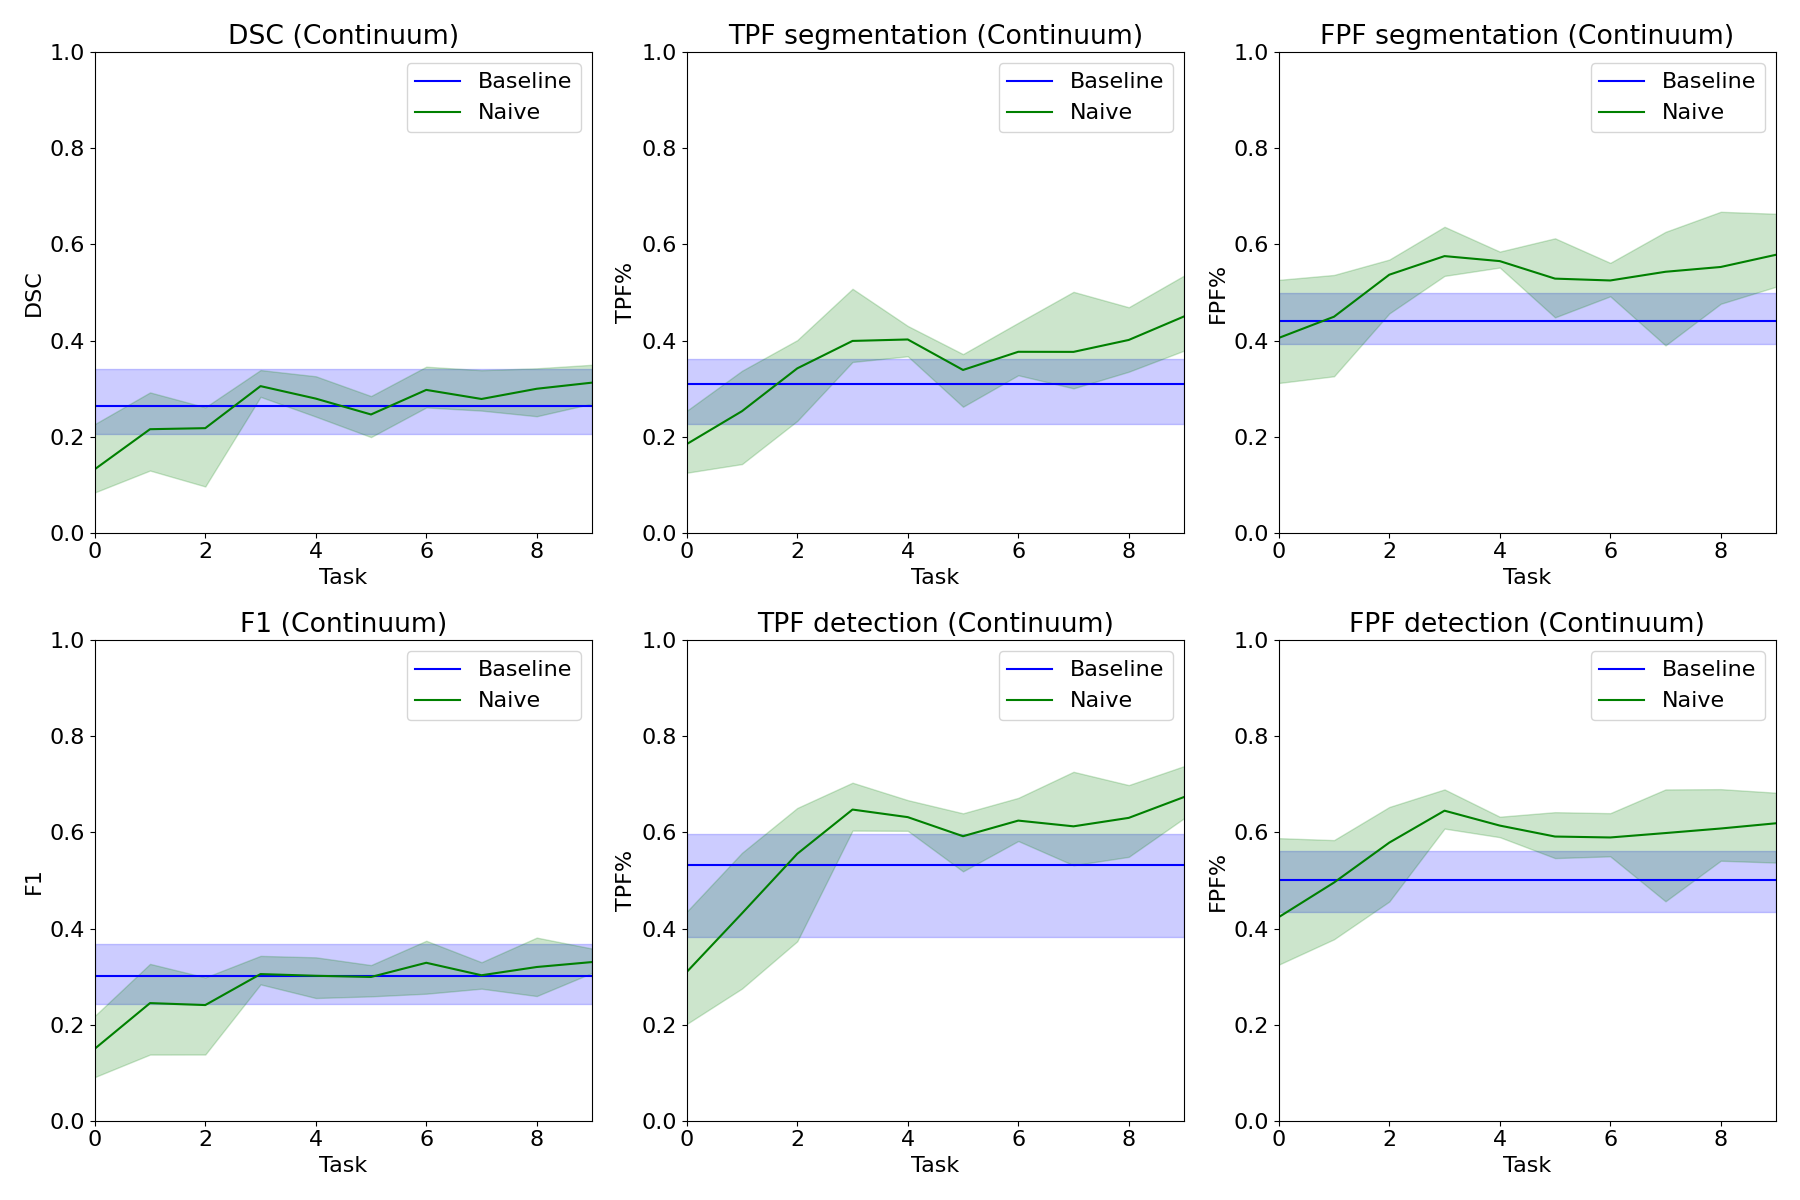

<IPython.core.display.Javascript object>


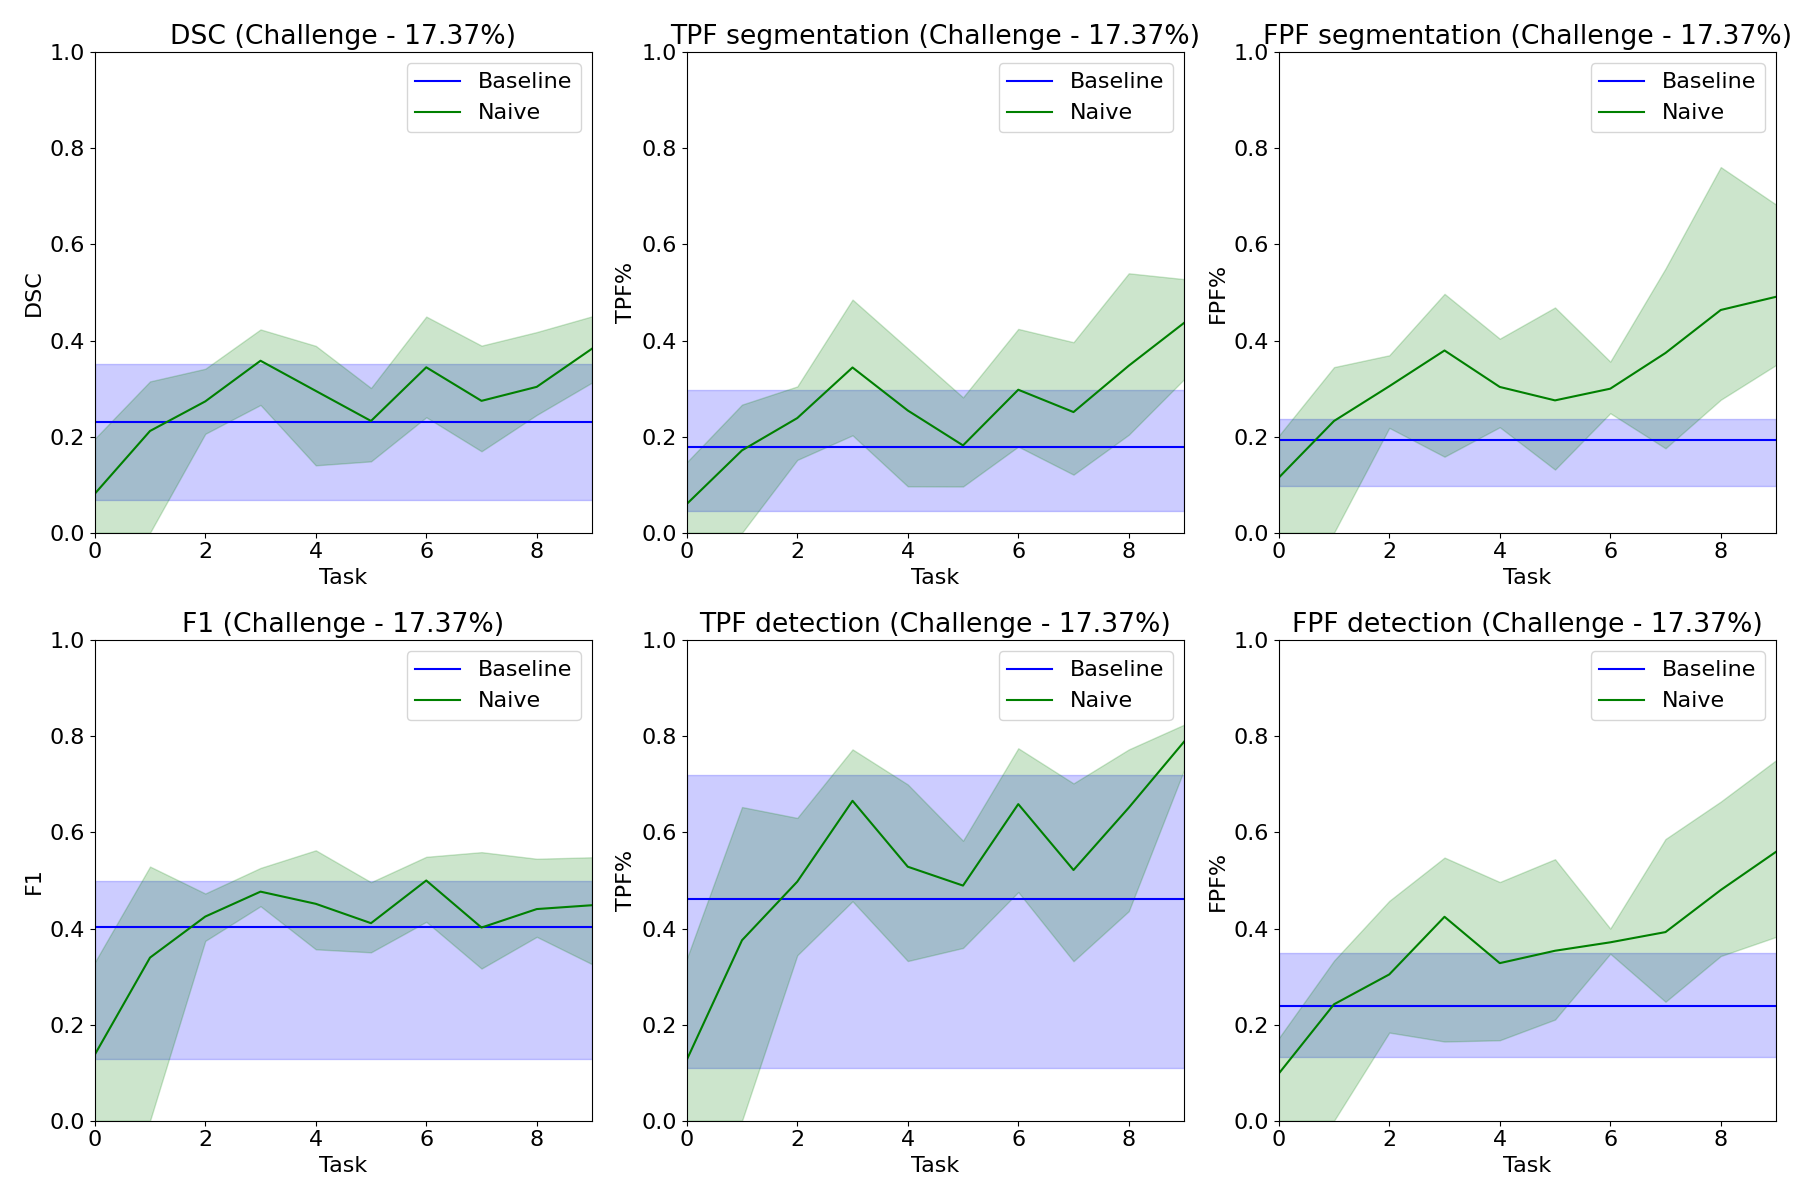

<IPython.core.display.Javascript object>


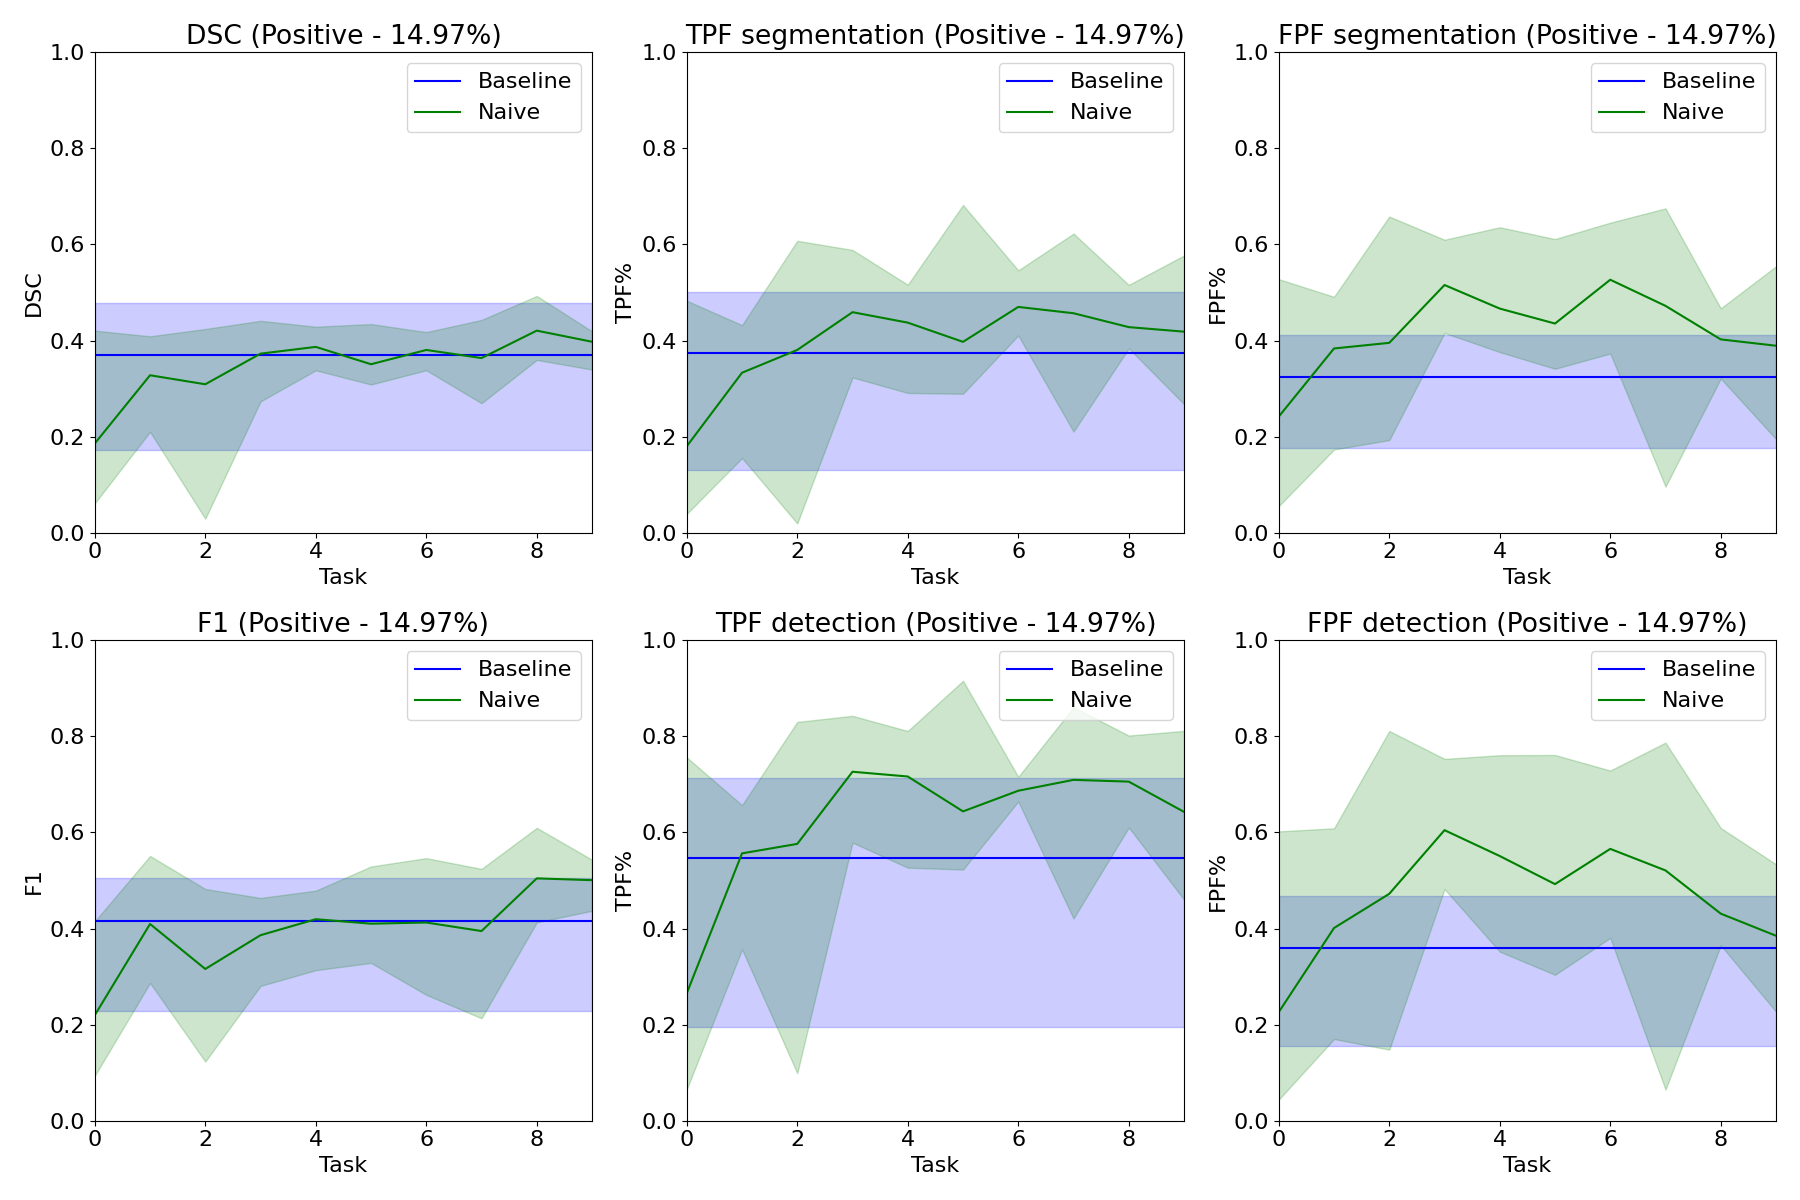

<IPython.core.display.Javascript object>


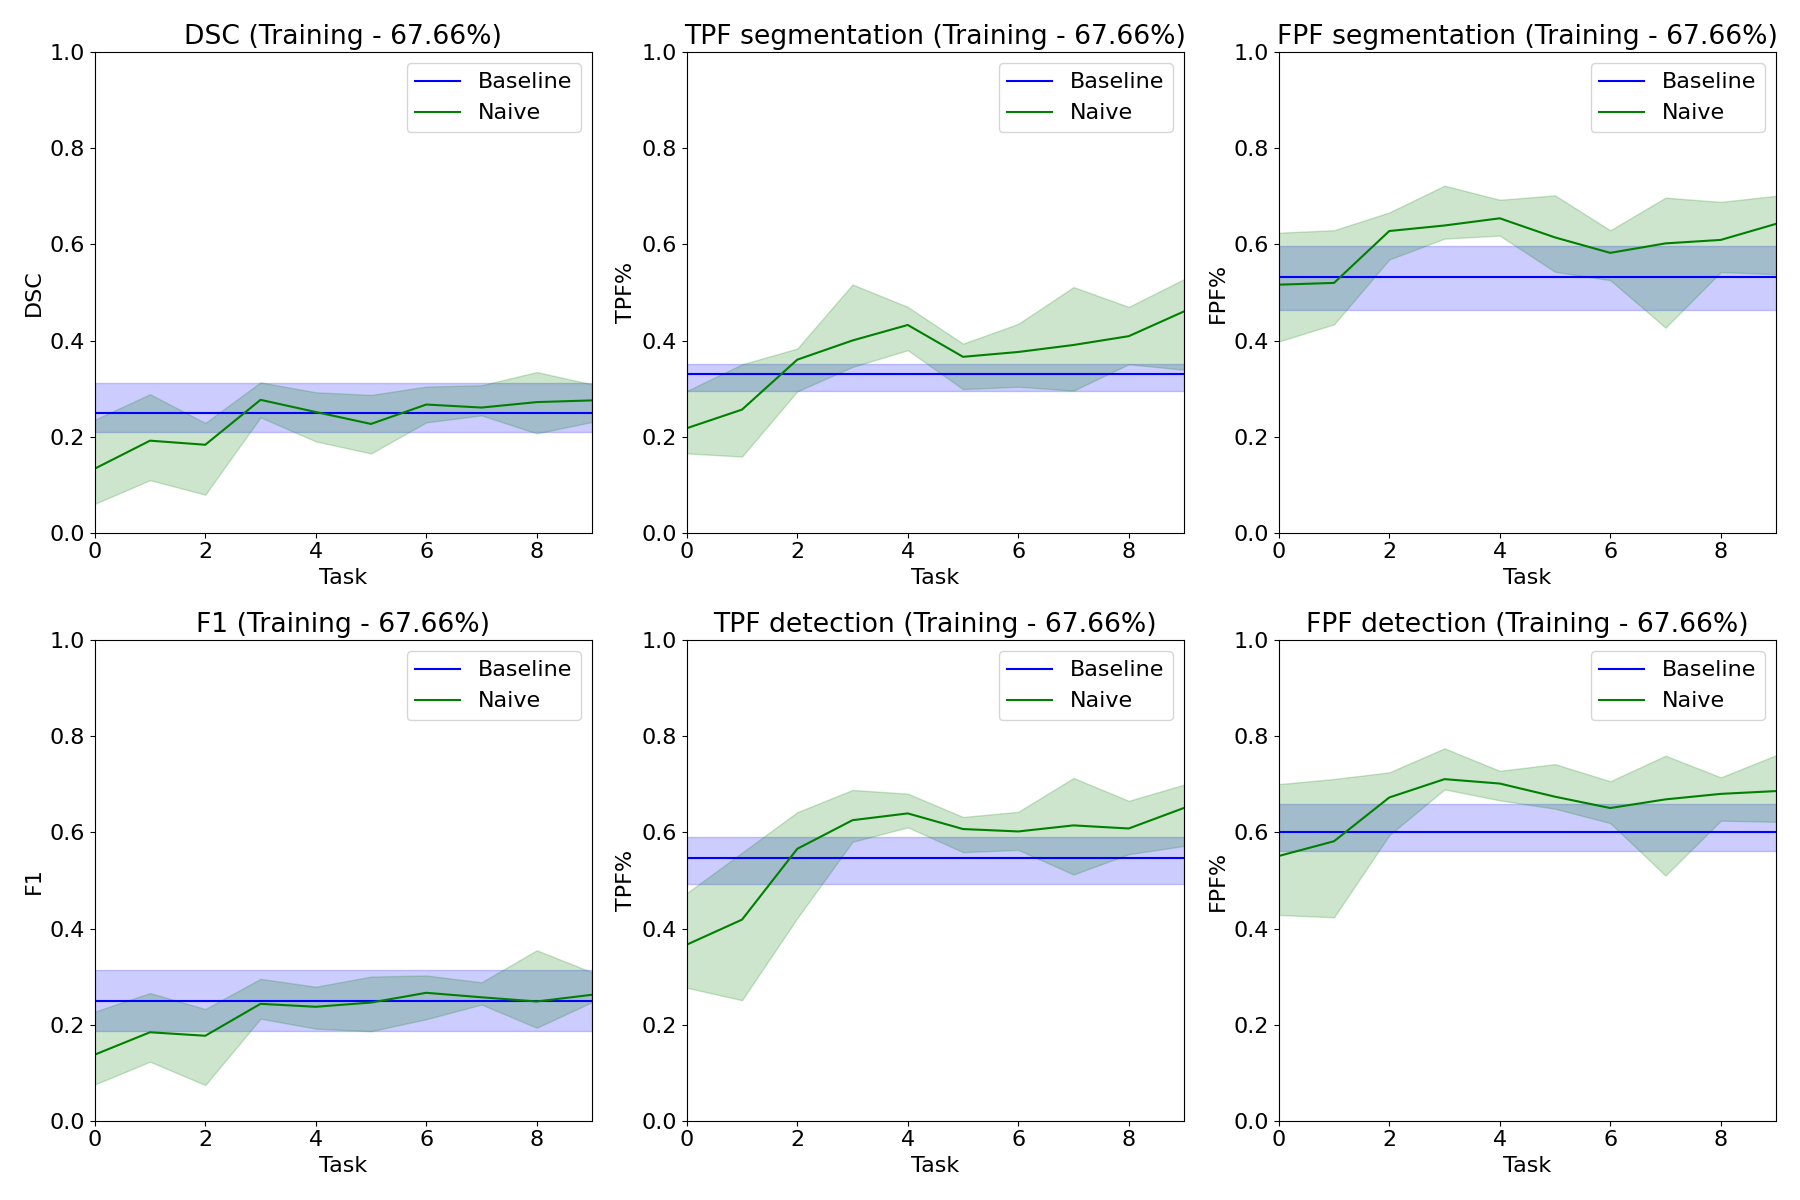

In [101]:
import os
import json
import numpy as np
json_path = '/media/transcend/IncrementalLearning/Masks/Activity/'
out_path = '/media/transcend/IncrementalLearning/Plots/Activity/'
naive_file = 'activity_unet-naive_testing.json'
bl_file = 'activity_unet-baseline_testing.json'

json_file = os.path.join(json_path, naive_file)
with open(json_file, 'r') as testing_json:
    naive_results = json.load(testing_json)
    
json_file = os.path.join(json_path, bl_file)
with open(json_file, 'r') as testing_json:
    bl_results = json.load(testing_json)
    

positive_naive = {
    sub: data
    for sub, data in naive_results.items() if 'CHN' not in sub and 'NEG' not in sub
}
chp_naive = {
    sub: data
    for sub, data in naive_results.items() if 'CHP' in sub
}
pos_naive = {
    sub: data
    for sub, data in naive_results.items() if 'POS' in sub
}
train_naive = {
    sub: data
    for sub, data in naive_results.items()
    if not np.any([tag in sub for tag in ['NEG', 'CHN', 'CHP', 'POS']]).any()
}

positive_bl = {
    sub: data
    for sub, data in bl_results.items() if 'CHN' not in sub and 'NEG' not in sub
}
chp_bl = {
    sub: data
    for sub, data in bl_results.items() if 'CHP' in sub
}
pos_bl = {
    sub: data
    for sub, data in bl_results.items() if 'POS' in sub
}
train_bl = {
    sub: data
    for sub, data in bl_results.items()
    if not np.any([tag in sub for tag in ['NEG', 'CHN', 'CHP', 'POS']]).any()
}

plot_metrics(positive_bl, positive_naive, 'Continuum', os.path.join(json_path, 'continuum_test_plots.png'))
plot_metrics(
    chp_bl, chp_naive, 'Challenge - {:5.2f}%'.format(100 * len(chp_bl) / len(positive_bl)),
    os.path.join(json_path, 'chp_test_plots.png')
)
plot_metrics(
    pos_bl, pos_naive, 'Positive - {:5.2f}%'.format(100 * len(pos_bl) / len(positive_bl)),
    os.path.join(json_path, 'pos_test_plots.png')
)
plot_metrics(
    train_bl, train_naive, 'Training - {:5.2f}%'.format(100 * len(train_bl) / len(positive_bl)),
    os.path.join(json_path, 'trainset_test_plots.png')
)

In [7]:
dsc_bl_list = []
dsc_naive_list = []
dtpf_bl_list = []
dtpf_naive_list = []
f1_bl_list = []
f1_naive_list = []

naive_file = 'activity_unet-naive_training.json'
bl_file = 'activity_unet-baseline_training.json'

json_file = os.path.join(json_path, naive_file)
with open(json_file, 'r') as testing_json:
    naive_results = json.load(testing_json)

json_file = os.path.join(json_path, bl_file)
with open(json_file, 'r') as testing_json:
    bl_results = json.load(testing_json)

for seed in ['42', '80702', '74794', '62021', '48497']:
    for fold in range(5):

        positive_naive = [{
            sub: data
            for sub, data in task_results.items() if 'CHN' not in sub and 'NEG' not in sub
        } for task_results in naive_results[str(seed)]['training'][fold]]
        chp_naive = [{
            sub: data
            for sub, data in task_results.items() if 'CHP' in sub
        } for task_results in naive_results[str(seed)]['training'][fold]]
        pos_naive = [{
            sub: data
            for sub, data in task_results.items() if 'POS' in sub
        } for task_results in naive_results[str(seed)]['training'][fold]]
        train_naive = [{
            sub: data
            for sub, data in task_results.items()
            if not np.any([tag in sub for tag in ['NEG', 'CHN', 'CHP', 'POS']]).any()
        } for task_results in naive_results[str(seed)]['training'][fold]]

        positive_bl = [{
            sub: data
            for sub, data in task_results.items() if 'CHN' not in sub and 'NEG' not in sub
        } for task_results in bl_results[str(seed)]['training'][fold]]
        chp_bl = [{
            sub: data
            for sub, data in task_results.items() if 'CHP' in sub
        } for task_results in bl_results[str(seed)]['training'][fold]]
        pos_bl = [{
            sub: data
            for sub, data in task_results.items() if 'POS' in sub
        } for task_results in bl_results[str(seed)]['training'][fold]]
        train_bl = [{
            sub: data
            for sub, data in task_results.items()
            if not np.any([tag in sub for tag in ['NEG', 'CHN', 'CHP', 'POS']]).any()
        } for task_results in bl_results[str(seed)]['training'][fold]]

        dsc_bl, dsc_naive, dtpf_bl, dtpf_naive, f1_bl, f1_naive = plot_train_metrics(
            positive_bl, positive_naive, 'Continuum',
            os.path.join(json_path, 'continuum_train_plots_f{:d}_s{:}.png'.format(fold, seed)),
            seed, fold
        )
        
        dsc_bl_list.append(dsc_bl)
        dsc_naive_list.append(dsc_naive)
        dtpf_bl_list.append(dtpf_bl)
        dtpf_naive_list.append(dtpf_naive)
        f1_bl_list.append(f1_bl)
        f1_naive_list.append(f1_naive)

<IPython.core.display.Javascript object>


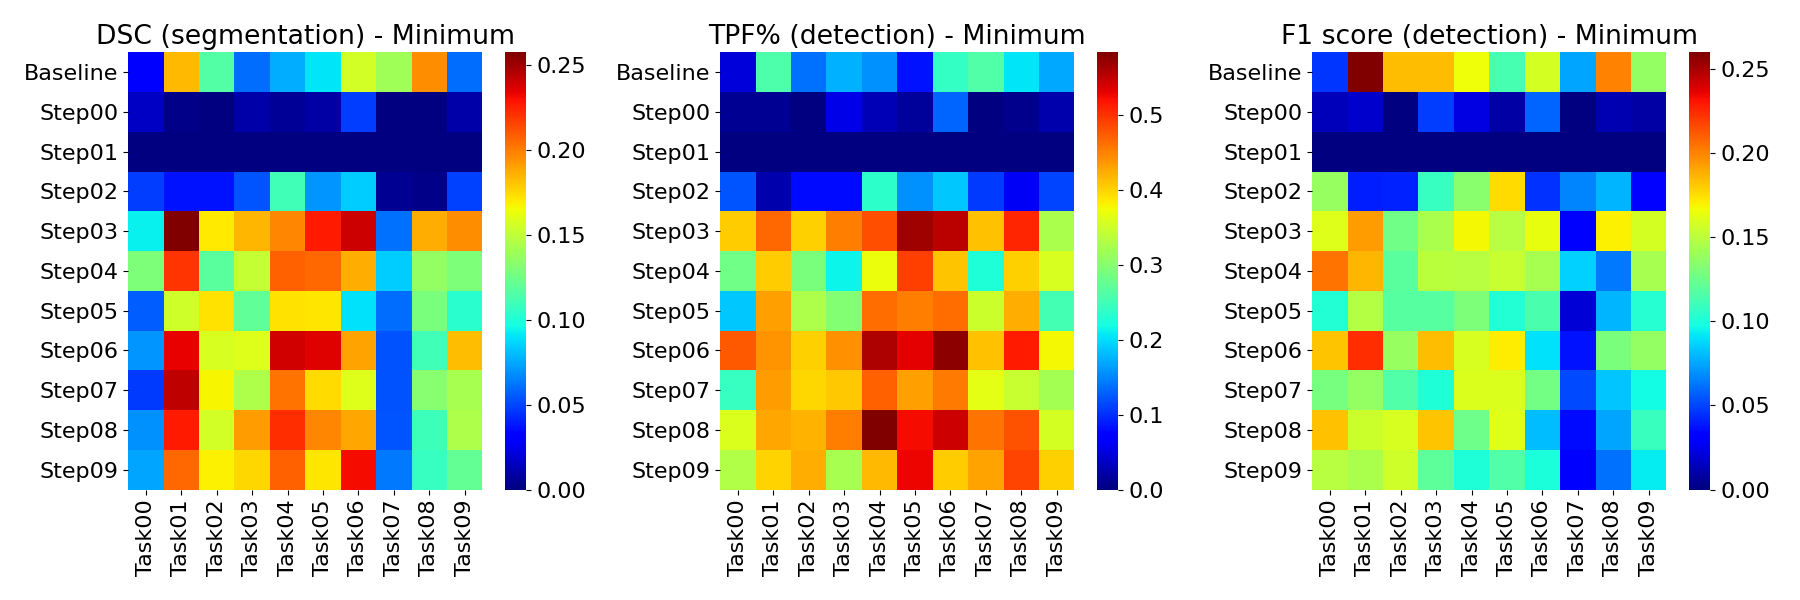

<IPython.core.display.Javascript object>


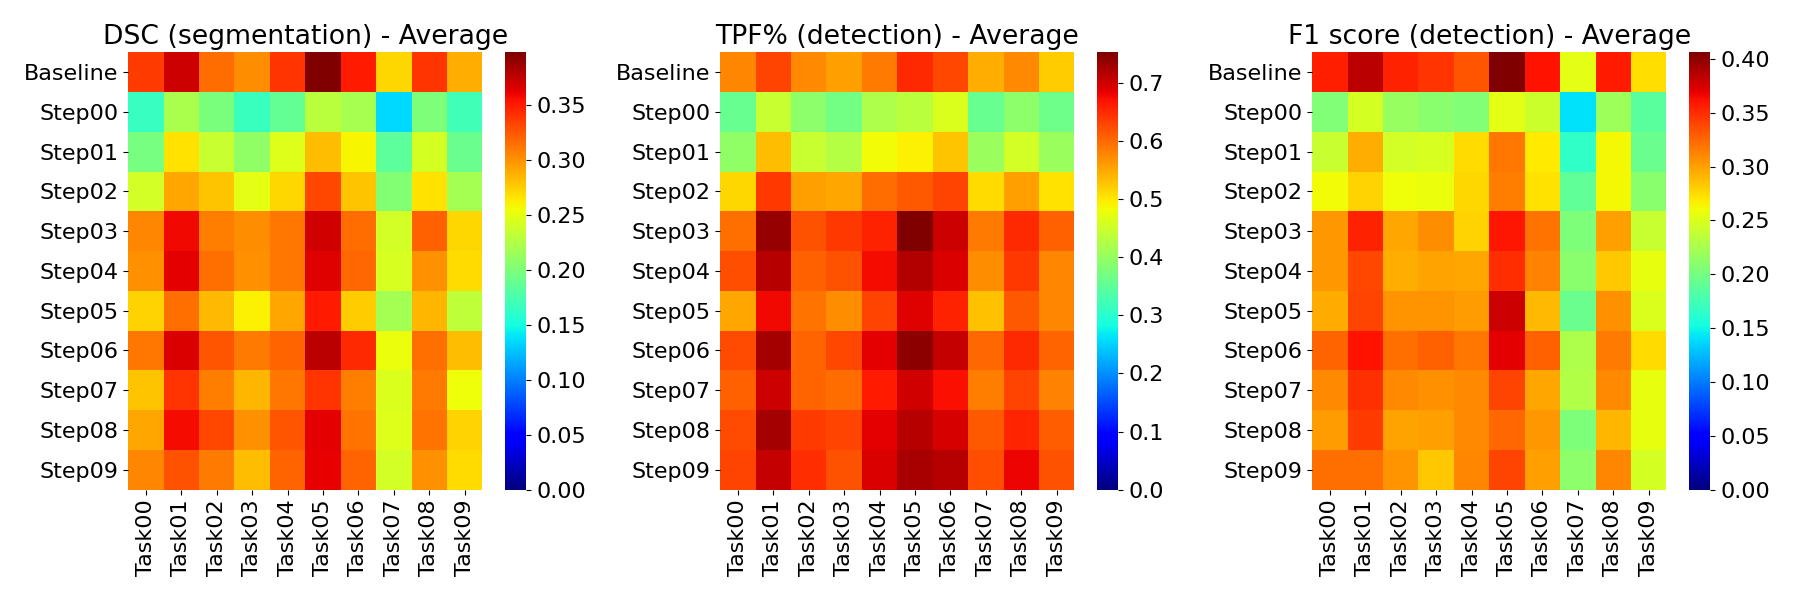

<IPython.core.display.Javascript object>


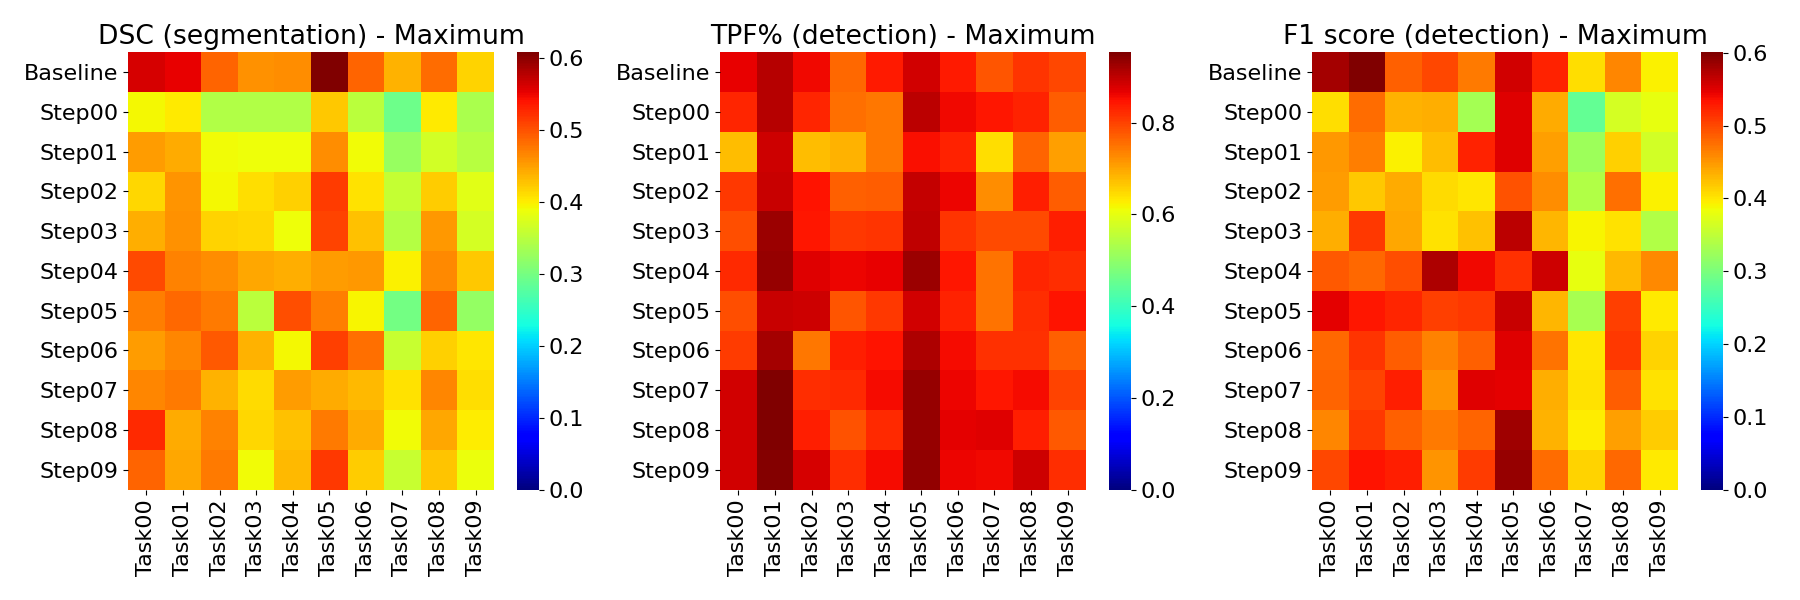

In [8]:
fig = plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
sn.heatmap(
    np.concatenate([np.min(dsc_bl_list, axis=0), np.min(dsc_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('DSC (segmentation) - Minimum')

ax = plt.subplot(1, 3, 2)
sn.heatmap(
    np.concatenate([np.min(dtpf_bl_list, axis=0), np.min(dtpf_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('TPF% (detection) - Minimum')

ax = plt.subplot(1, 3, 3)
sn.heatmap(
    np.concatenate([np.min(f1_bl_list, axis=0), np.min(f1_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('F1 score (detection) - Minimum')

plt.tight_layout()
plt.savefig(os.path.join(json_path, 'continuum_train_plots_min.png'.format(fold, seed)))


fig = plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
sn.heatmap(
    np.concatenate([np.mean(dsc_bl_list, axis=0), np.mean(dsc_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('DSC (segmentation) - Average')

ax = plt.subplot(1, 3, 2)
sn.heatmap(
    np.concatenate([np.mean(dtpf_bl_list, axis=0), np.mean(dtpf_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('TPF% (detection) - Average')

ax = plt.subplot(1, 3, 3)
sn.heatmap(
    np.concatenate([np.mean(f1_bl_list, axis=0), np.mean(f1_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('F1 score (detection) - Average')

plt.tight_layout()
plt.savefig(os.path.join(json_path, 'continuum_train_plots_mean.png'.format(fold, seed)))


fig = plt.figure(figsize=(18, 6))
ax = plt.subplot(1, 3, 1)
sn.heatmap(
    np.concatenate([np.max(dsc_bl_list, axis=0), np.max(dsc_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('DSC (segmentation) - Maximum')

ax = plt.subplot(1, 3, 2)
sn.heatmap(
    np.concatenate([np.max(dtpf_bl_list, axis=0), np.max(dtpf_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('TPF% (detection) - Maximum')

ax = plt.subplot(1, 3, 3)
sn.heatmap(
    np.concatenate([np.max(f1_bl_list, axis=0), np.max(f1_naive_list, axis=0)]),
    cmap='jet', vmin=0, xticklabels=['Task{:02d}'.format(si) for si in range(10)],
    yticklabels=['Baseline'] + ['Step{:02d}'.format(si) for si in range(10)]
)
plt.title('F1 score (detection) - Maximum')

plt.tight_layout()
plt.savefig(os.path.join(json_path, 'continuum_train_plots_max.png'.format(fold, seed)))

<IPython.core.display.Javascript object>


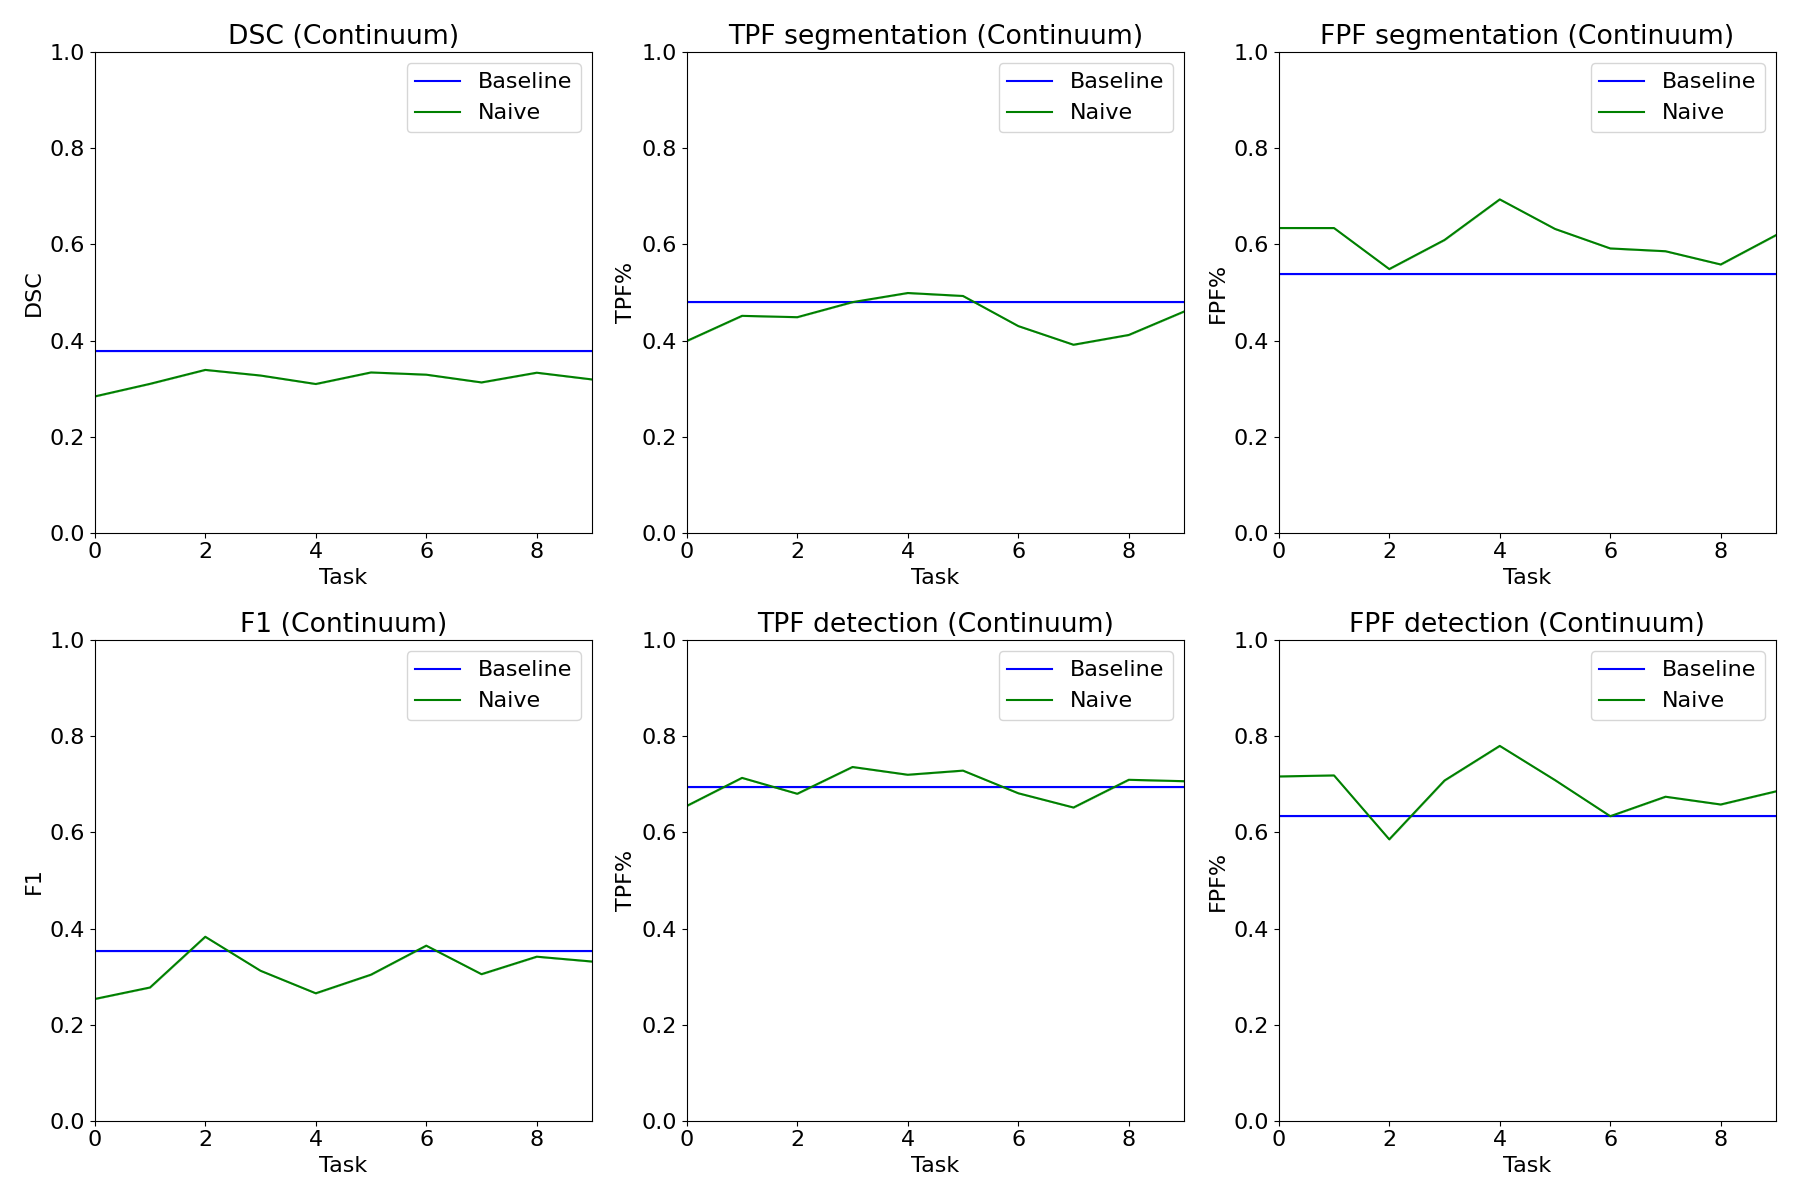

<IPython.core.display.Javascript object>


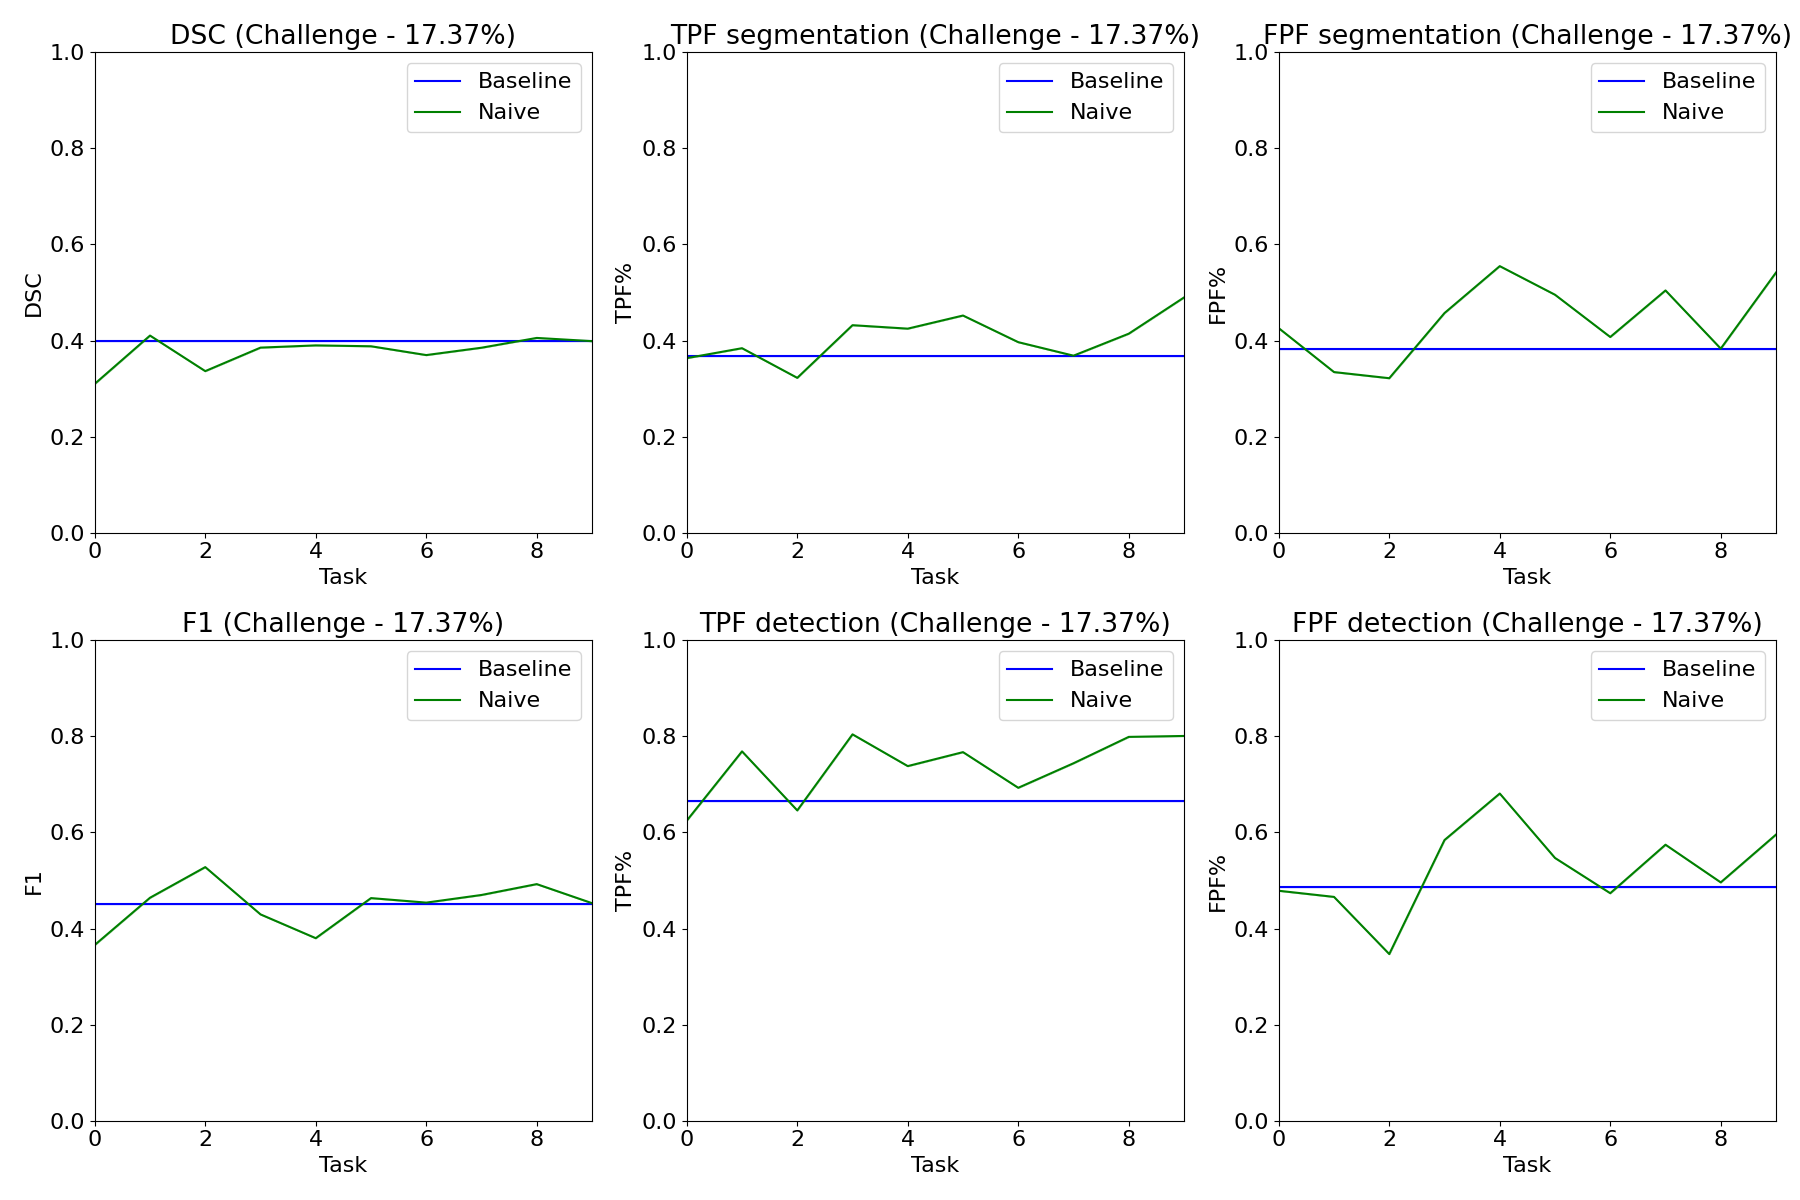

<IPython.core.display.Javascript object>


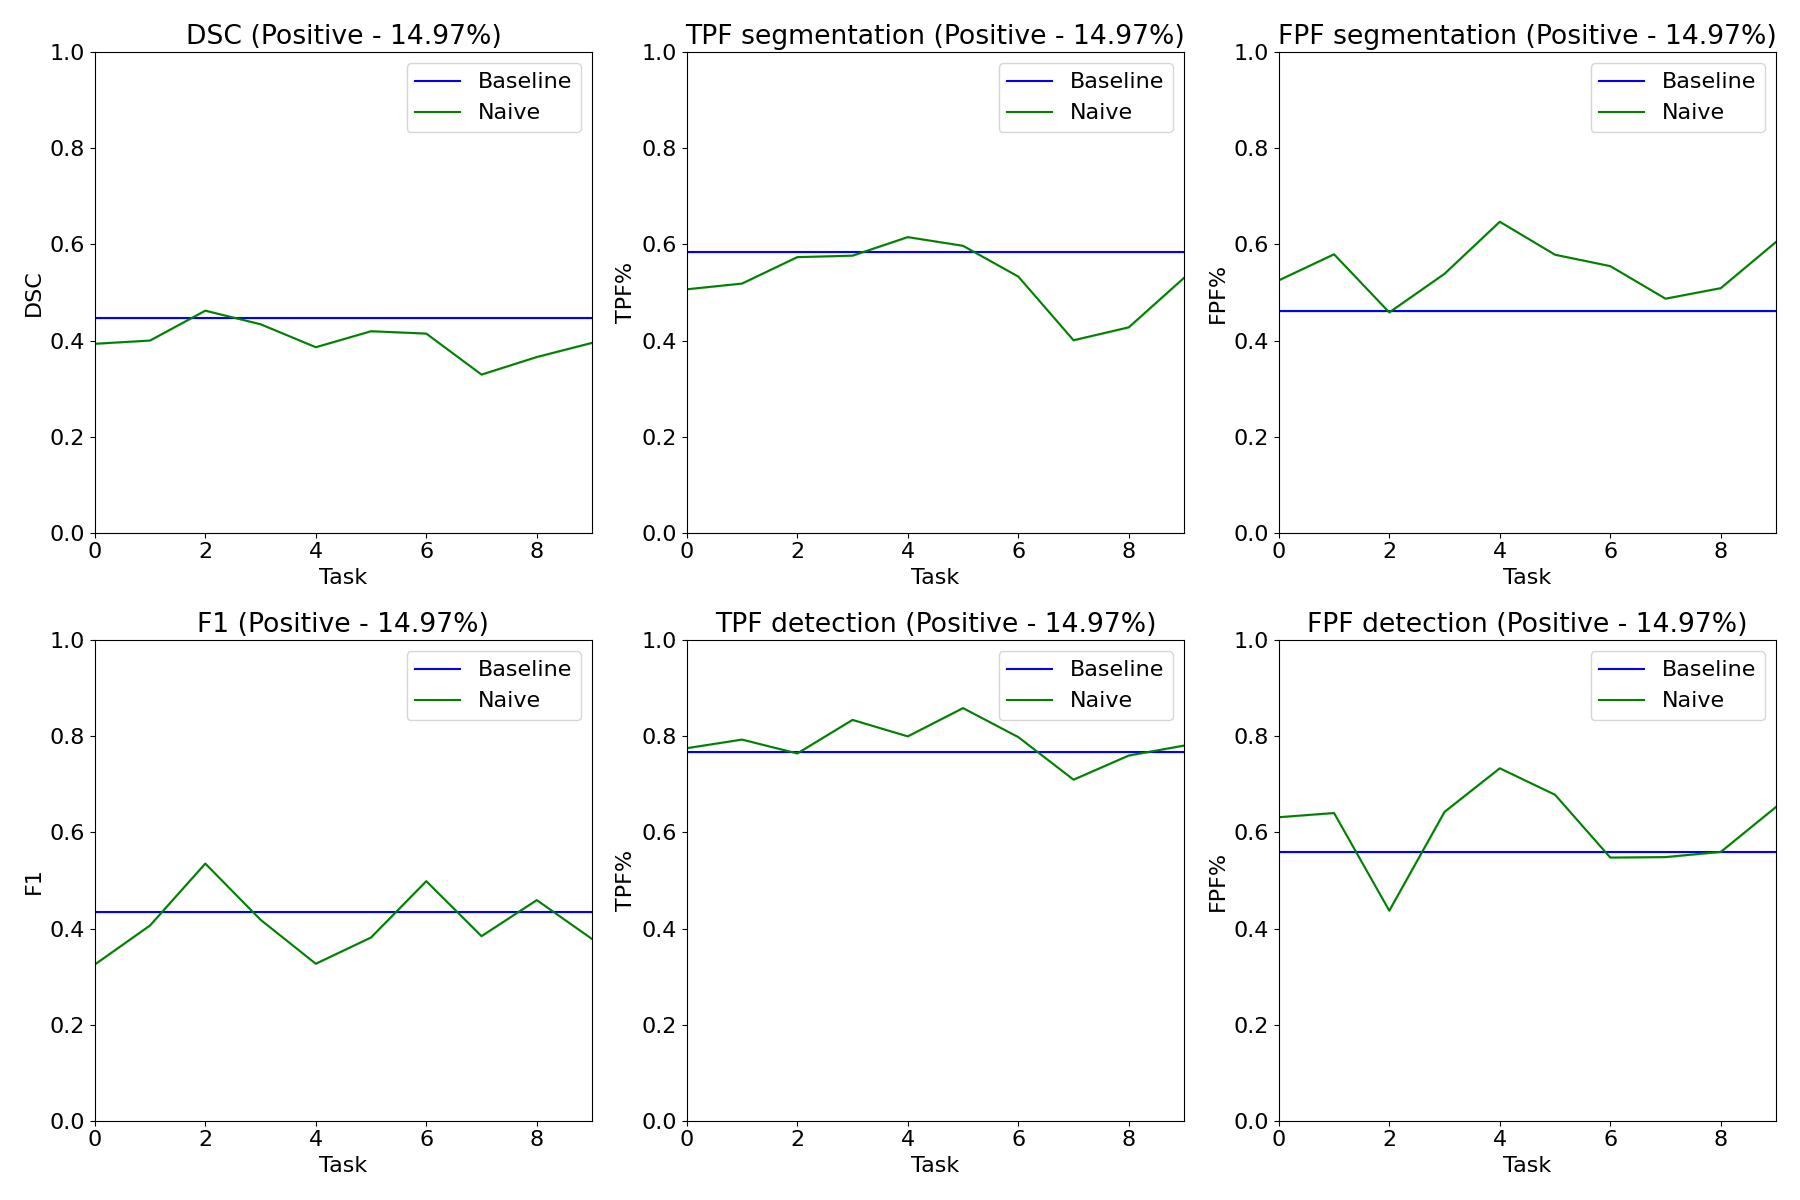

<IPython.core.display.Javascript object>


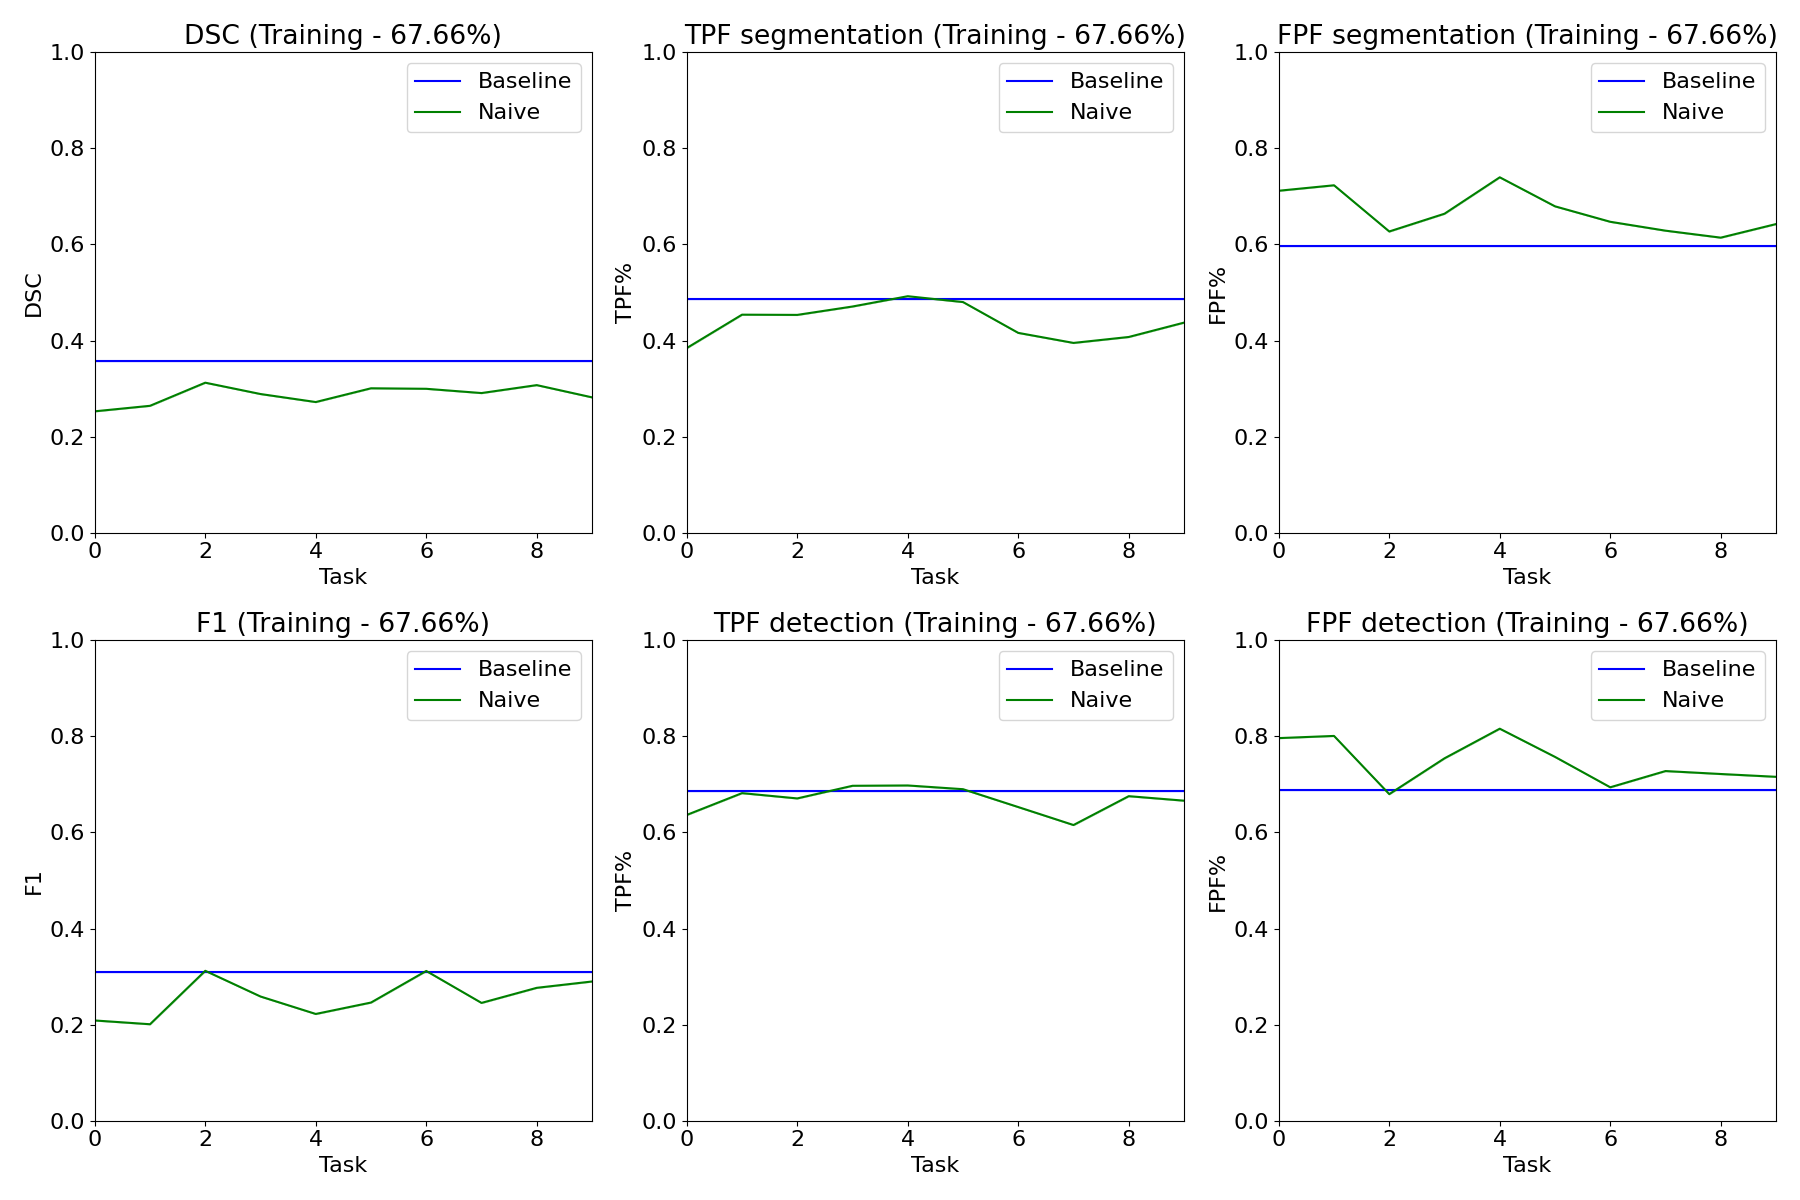

In [102]:
import os
import json
import numpy as np
json_path = '/media/transcend/IncrementalLearning/Masks/Activity/'
out_path = '/media/transcend/IncrementalLearning/Plots/Activity/'
naive_file = 'activity_positive-naive_test.f4.s42.t09.json'
bl_file = 'activity_positive-baseline_testing.f4.s42.json'

json_file = os.path.join(json_path, naive_file)
with open(json_file, 'r') as testing_json:
    naive_results = json.load(testing_json)
    
json_file = os.path.join(json_path, bl_file)
with open(json_file, 'r') as testing_json:
    bl_results = json.load(testing_json)    

positive_naive = {
    sub: data
    for sub, data in naive_results.items() if 'CHN' not in sub and 'NEG' not in sub
}
chp_naive = {
    sub: data
    for sub, data in naive_results.items() if 'CHP' in sub
}
pos_naive = {
    sub: data
    for sub, data in naive_results.items() if 'POS' in sub
}
train_naive = {
    sub: data
    for sub, data in naive_results.items()
    if not np.any([tag in sub for tag in ['NEG', 'CHN', 'CHP', 'POS']]).any()
}

positive_bl = {
    sub: data
    for sub, data in bl_results.items() if 'CHN' not in sub and 'NEG' not in sub
}
chp_bl = {
    sub: data
    for sub, data in bl_results.items() if 'CHP' in sub
}
pos_bl = {
    sub: data
    for sub, data in bl_results.items() if 'POS' in sub
}
train_bl = {
    sub: data
    for sub, data in bl_results.items()
    if not np.any([tag in sub for tag in ['NEG', 'CHN', 'CHP', 'POS']]).any()
}

plot_metrics(
    positive_bl, positive_naive, 'Continuum',
    os.path.join(json_path, 'continuum_test_plots.png'),
    seeds=['42']
)
plot_metrics(
    chp_bl, chp_naive, 'Challenge - {:5.2f}%'.format(100 * len(chp_bl) / len(positive_bl)),
    os.path.join(json_path, 'chp_test_plots.png'),
    seeds=['42']
)
plot_metrics(
    pos_bl, pos_naive, 'Positive - {:5.2f}%'.format(100 * len(pos_bl) / len(positive_bl)),
    os.path.join(json_path, 'pos_test_plots.png'),
    seeds=['42']
)
plot_metrics(
    train_bl, train_naive, 'Training - {:5.2f}%'.format(100 * len(train_bl) / len(positive_bl)),
    os.path.join(json_path, 'trainset_test_plots.png'),
    seeds=['42']
)

<IPython.core.display.Javascript object>


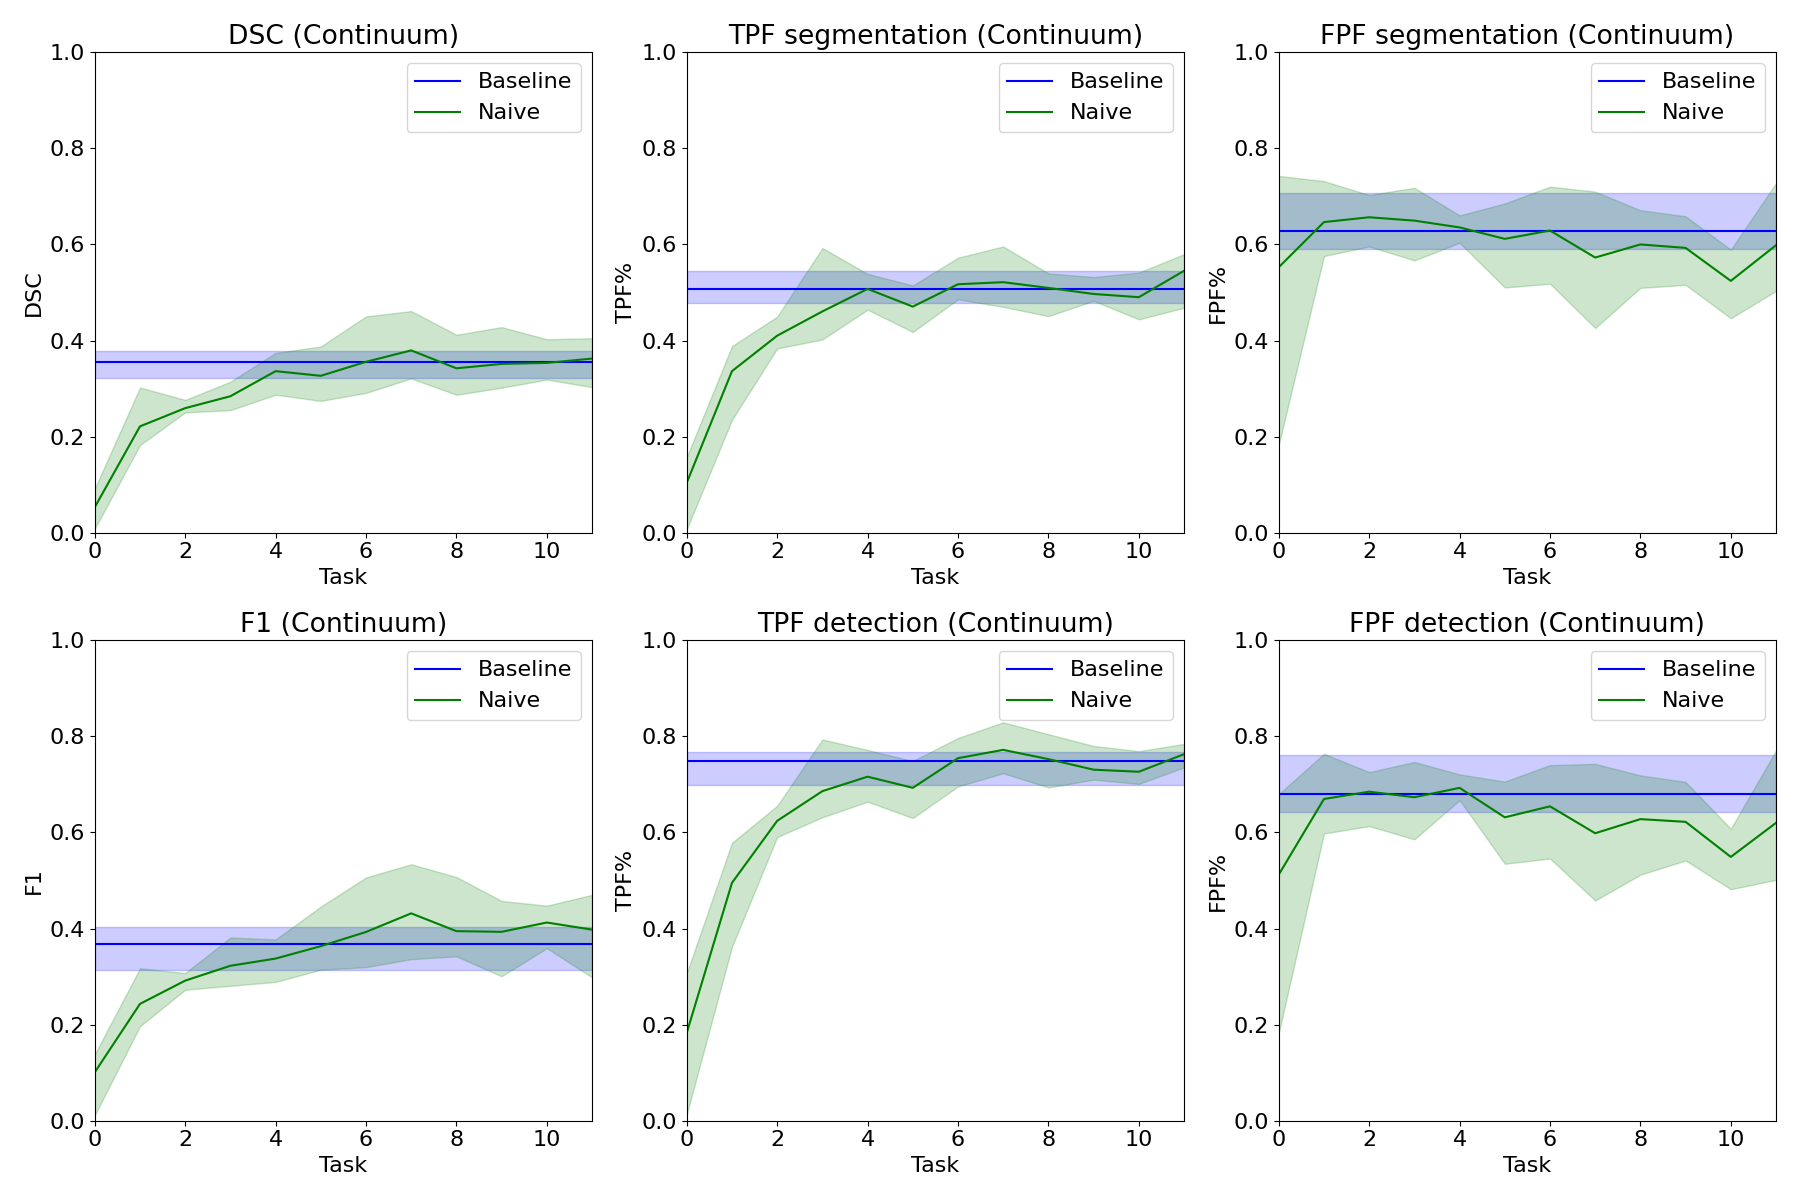

<IPython.core.display.Javascript object>


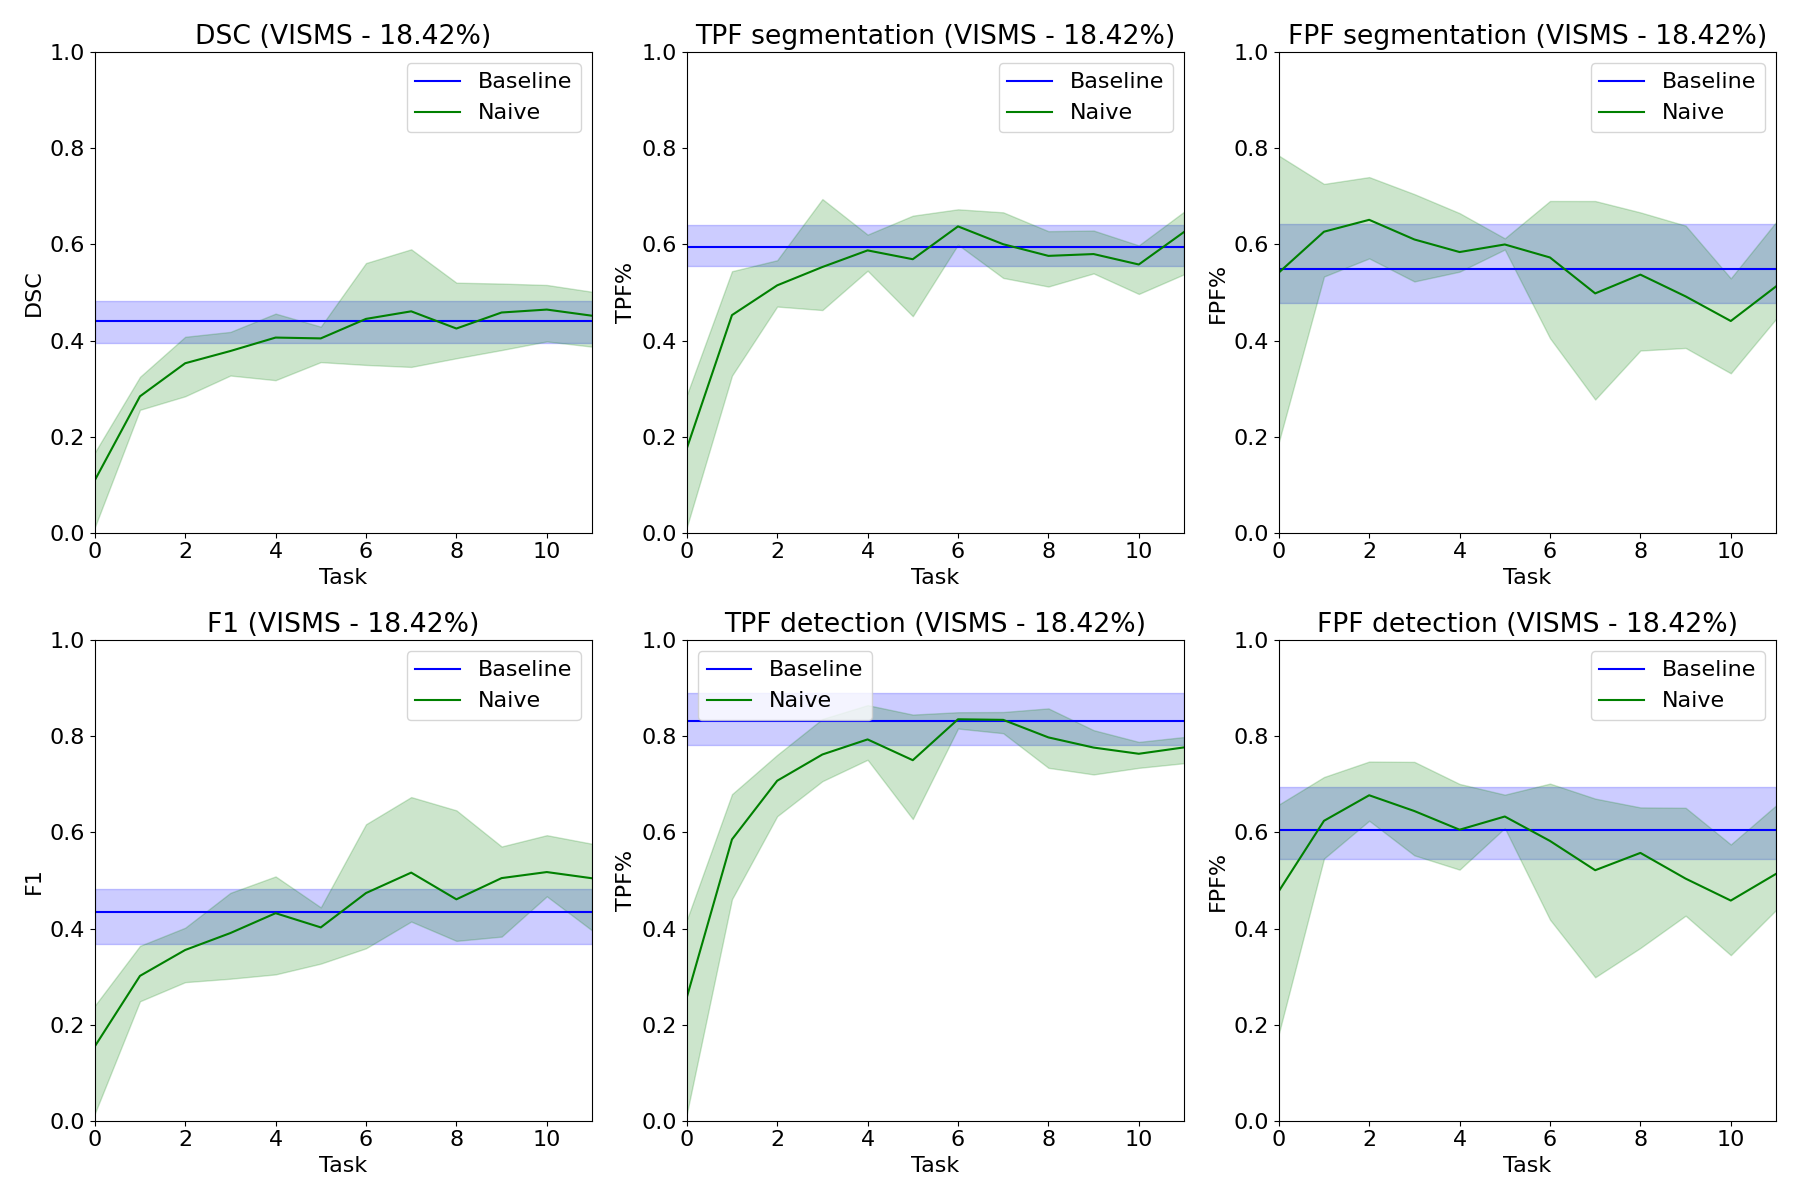

<IPython.core.display.Javascript object>


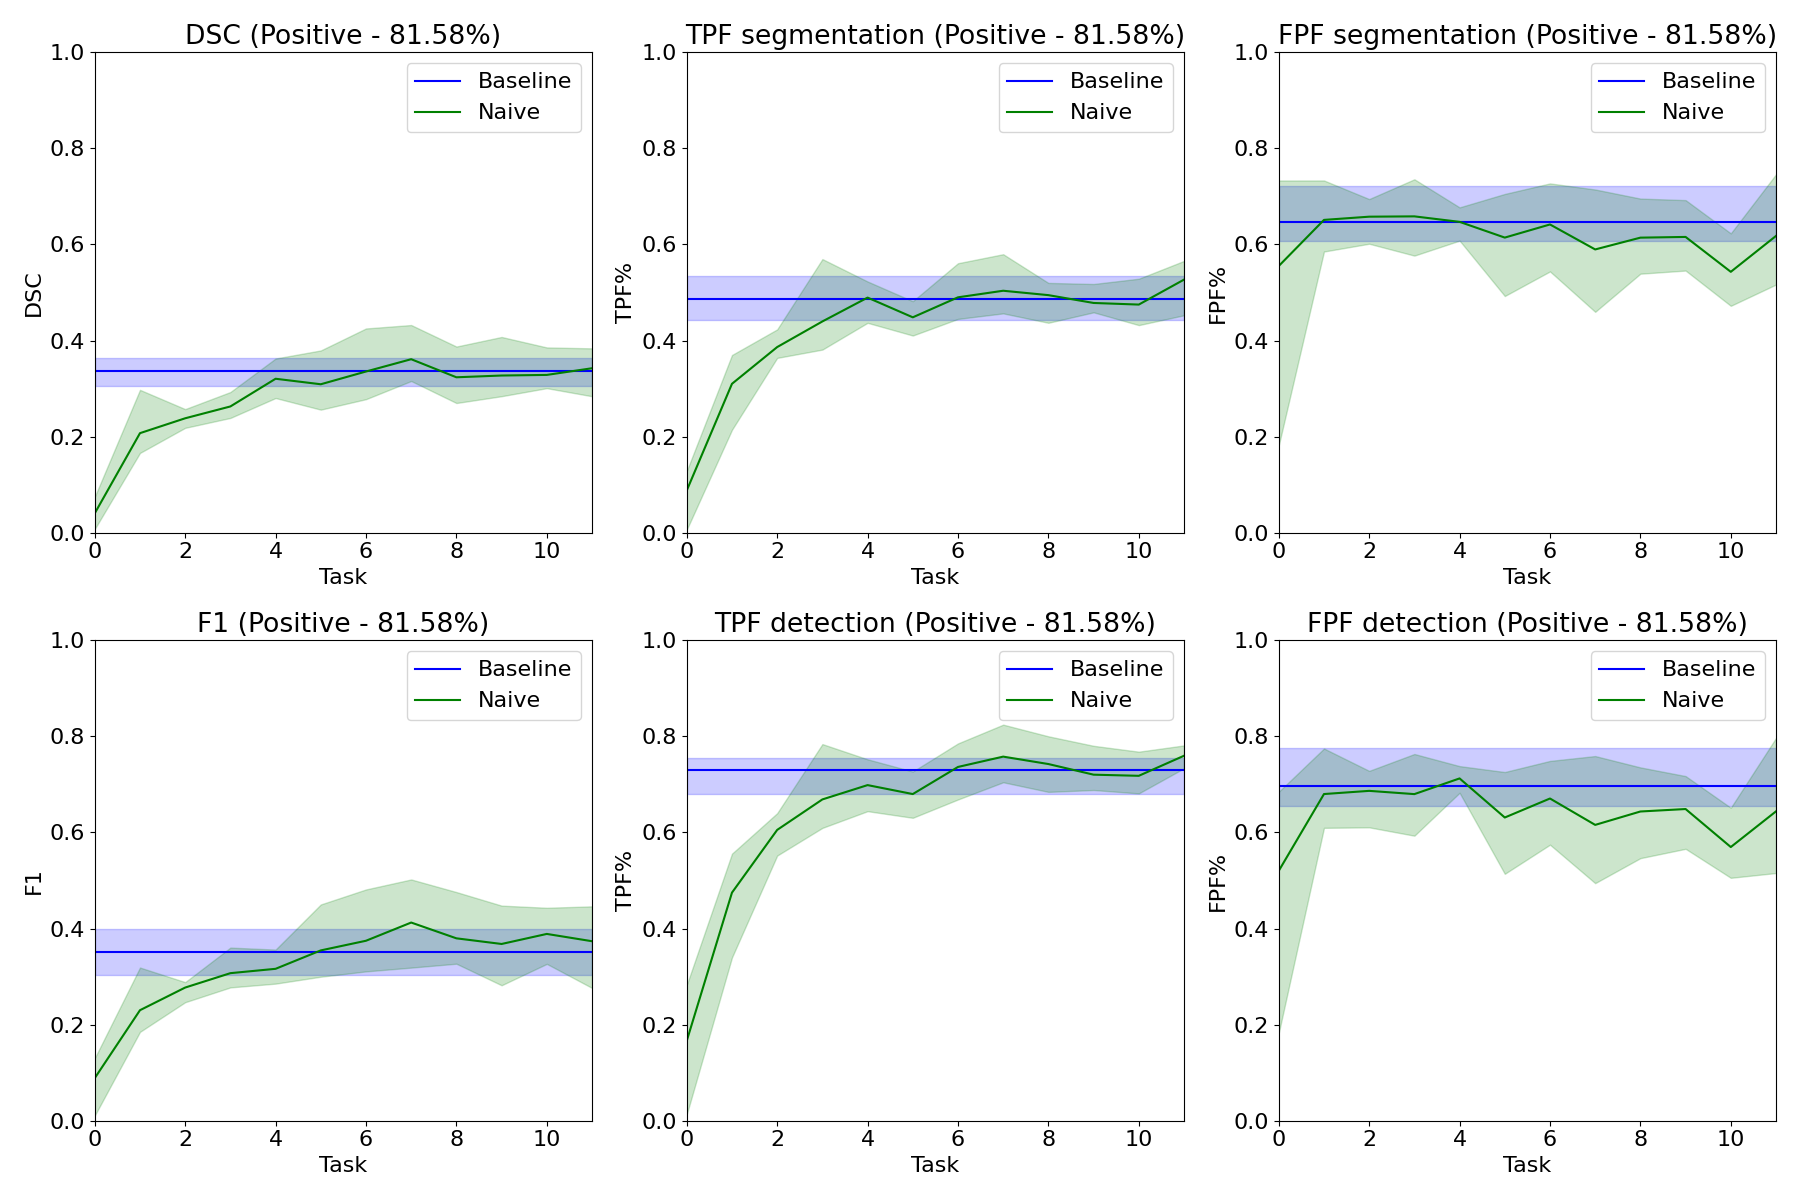

In [205]:
import os
import json
import numpy as np
json_path = '/media/transcend/IncrementalLearning/Masks/CEL/'
out_path = '/media/transcend/IncrementalLearning/Plots/CEL/'
naive_file = 'cel_unet-naive_test.f4.s62021.t11.json'
bl_file = 'cel_unet-baseline_testing.f4.s62021.json'

json_file = os.path.join(json_path, naive_file)
with open(json_file, 'r') as testing_json:
    naive_results = json.load(testing_json)
    
json_file = os.path.join(json_path, bl_file)
with open(json_file, 'r') as testing_json:
    bl_results = json.load(testing_json)

positive_naive = {
    '{:}_{:}'.format(sub, key): data
    for sub, session in naive_results.items() if 'POS' in sub or 'VIS' in sub
    for key, data in session.items()
}
vis_naive = {
    '{:}_{:}'.format(sub, key): data
    for sub, session in naive_results.items() if 'VIS' in sub
    for key, data in session.items()
}
pos_naive = {
    '{:}_{:}'.format(sub, key): data
    for sub, session in naive_results.items() if 'POS' in sub
    for key, data in session.items()
}

positive_bl = {
    '{:}_{:}'.format(sub, key): data
    for sub, session in bl_results.items() if 'POS' in sub or 'VIS' in sub
    for key, data in session.items()
}
vis_bl = {
    '{:}_{:}'.format(sub, key): data
    for sub, session in bl_results.items() if 'VIS' in sub
    for key, data in session.items()
}
pos_bl = {
    '{:}_{:}'.format(sub, key): data
    for sub, session in bl_results.items() if 'POS' in sub
    for key, data in session.items()
}

plot_metrics(
    positive_bl, positive_naive, 'Continuum',
    os.path.join(json_path, 'continuum_test_plots.png'),
    n_tasks=12, seeds=['42', '80702', '74794', '62021']
)
plot_metrics(
    vis_bl, vis_naive, 'VISMS - {:5.2f}%'.format(100 * len(vis_bl) / len(positive_bl)),
    os.path.join(json_path, 'vis_test_plots.png'),
    n_tasks=12, seeds=['42', '80702', '74794', '62021']
)
plot_metrics(
    pos_bl, pos_naive, 'Positive - {:5.2f}%'.format(100 * len(pos_bl) / len(positive_bl)),
    os.path.join(json_path, 'pos_test_plots.png'),
    n_tasks=12, seeds=['42', '80702', '74794', '62021']
)

# Data analysis
This cell is unrelated to the results and its meant to be used to analyse the data we have and "ways" of creating possible shifts.

In [166]:
import pandas as pd
from skimage.measure import label as bwlabeln

tags = ['S3T', 'P1T', 'P3T', 'CHP', 'G3T', 'POS']
path = '/media/transcend/IncrementalLearning/Activity'
bl = 'flair01.nii.gz'
fu = 'flair02.nii.gz'
lesion = 'manual_mask.nii.gz'
brain = 'brain_mask.nii.gz'

subjects = sorted([
    patient for patient in os.listdir(path)
    if os.path.isdir(os.path.join(path, patient)) 
    and np.any([tag in patient for tag in tags])
])

subject_data = []
for pi, p in enumerate(subjects):
    task_found = False
    for tag in tags:
        task_found = tag in p
        if task_found:
            print(' '.join([' '] * 300), end='\r')
            print('Subject {:} [{:03d}/{:03d}]'.format(p, pi, len(subjects)), end='\r')
            p_path = os.path.join(path, p)
            brain_name = os.path.join(p_path, brain)
            brain_mask = nib.load(brain_name).get_fdata().astype(bool)
            lesion_name = os.path.join(p_path, lesion)
            lesion_mask = nib.load(lesion_name).get_fdata().astype(bool)
            notlesion_mask = np.logical_and(brain_mask, np.logical_not(lesion_mask))
            bl_name = os.path.join(p_path, bl)
            bl_image = nib.load(bl_name).get_fdata()
            fu_name = os.path.join(p_path, fu)
            fu_image = nib.load(fu_name).get_fdata()
            sub_image = fu_image - bl_image
            _, lesions = bwlabeln(lesion_mask, return_num=True)
            volume = np.sum(lesion_mask)
            mean_contrast = np.mean(sub_image[brain_mask])
            std_contrast = np.std(sub_image[brain_mask])
            brain_contrast = (np.mean(sub_image[notlesion_mask]) - mean_contrast) / std_contrast
            lesion_contrast = (np.mean(sub_image[lesion_mask]) - mean_contrast) / std_contrast
            diff_contrast = (lesion_contrast - brain_contrast) / std_contrast
            subject_data.append([
                tag, lesions, volume, volume / lesions,
                lesion_contrast, brain_contrast, diff_contrast
            ])

0  1     2           3         4         5         6
0    CHP  1    40   40.000000  3.142577 -0.000050  0.142657
1    CHP  6   743  123.833333  2.227292 -0.000641  0.008940
2    CHP  2   364  182.000000  1.806381 -0.000321  0.092789
3    CHP  1   201  201.000000  6.559723 -0.000239  0.673823
4    CHP  4  2227  556.750000  0.290084 -0.000209  0.001269
..   ... ..   ...         ...       ...       ...       ...
162  S3T  6   852  142.000000  2.272280 -0.000362  0.092370
163  S3T  3   769  256.333333  2.605000 -0.000411  0.095470
164  S3T  2   815  407.500000  3.966233 -0.000569  0.139043
165  S3T  6   574   95.666667  2.649858 -0.000284  0.088823
166  S3T  3   370  123.333333  3.253821 -0.000287  0.115555

[167 rows x 7 columns]

<IPython.core.display.Javascript object>


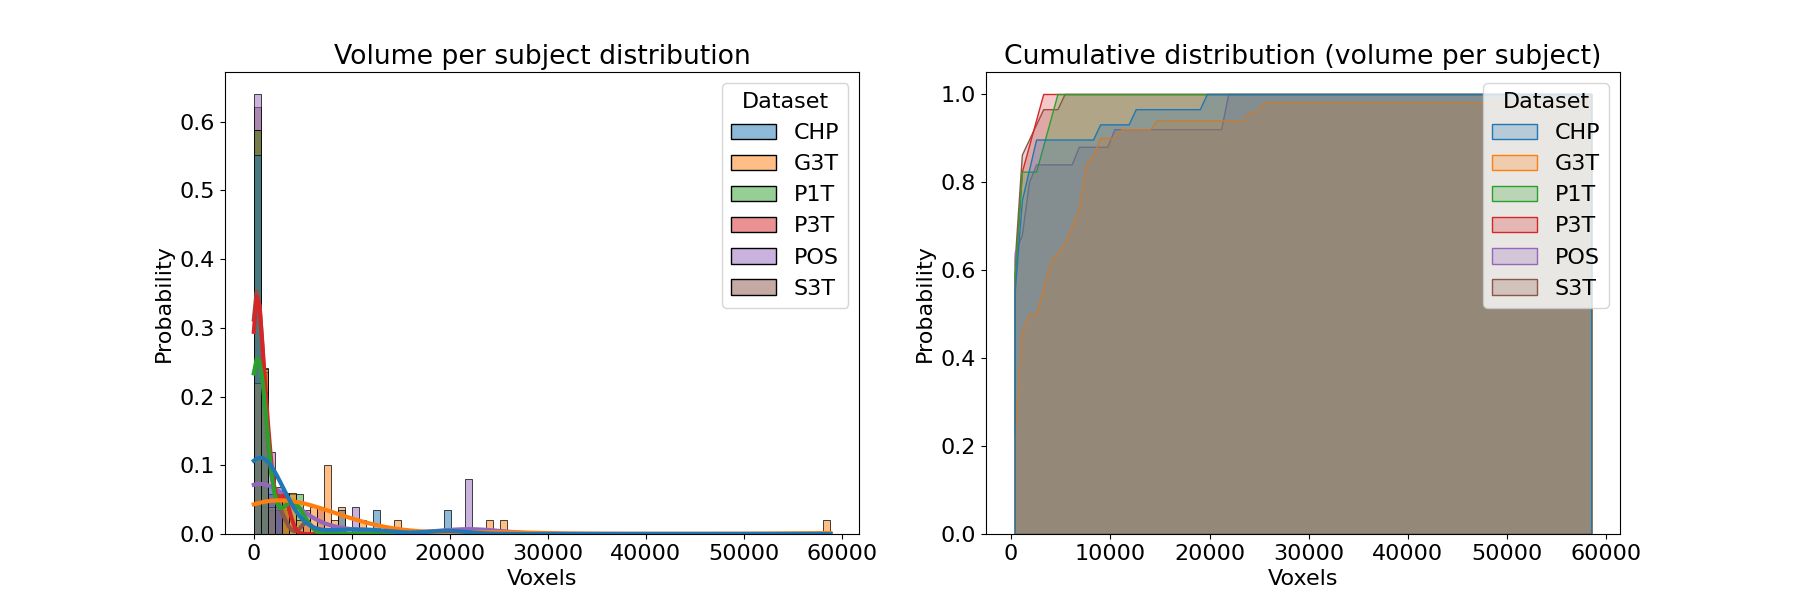

<IPython.core.display.Javascript object>


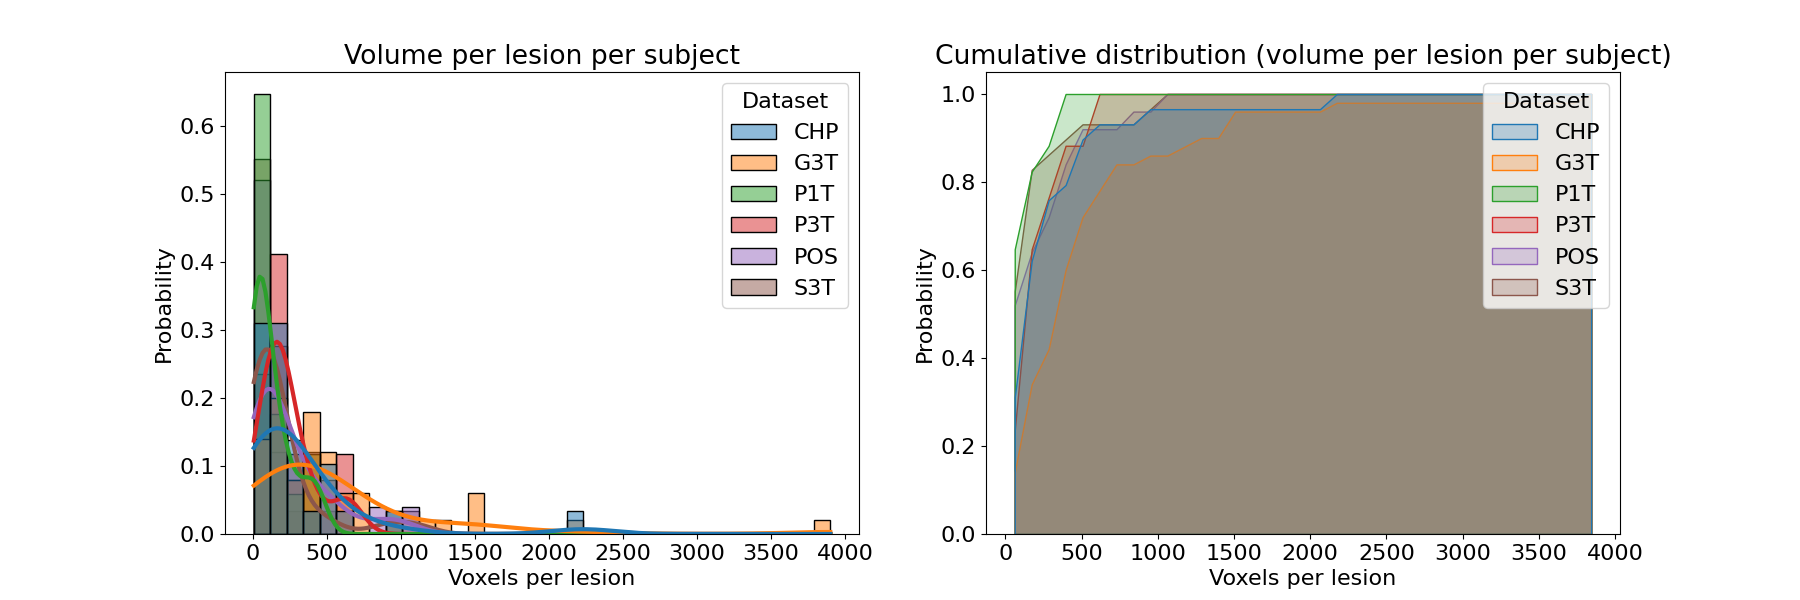

<IPython.core.display.Javascript object>


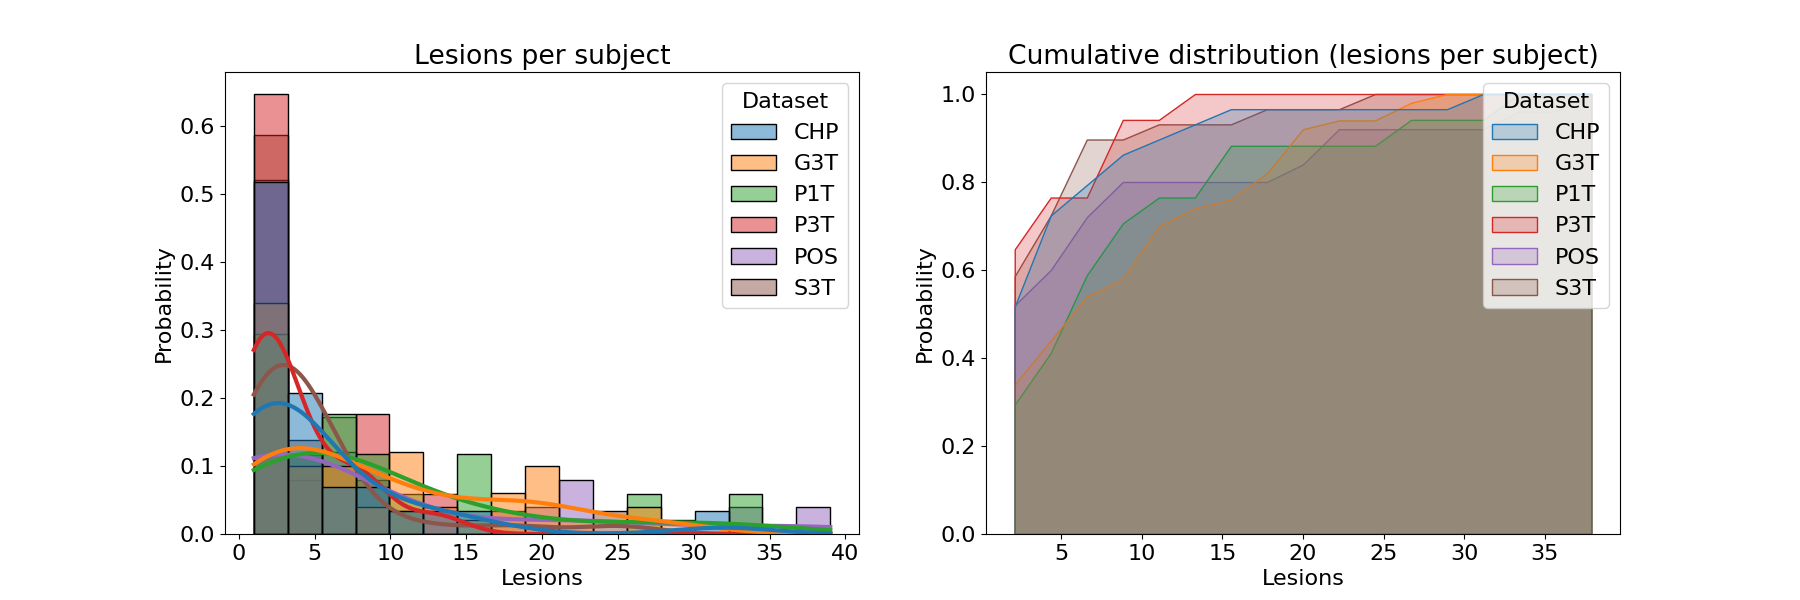

<IPython.core.display.Javascript object>


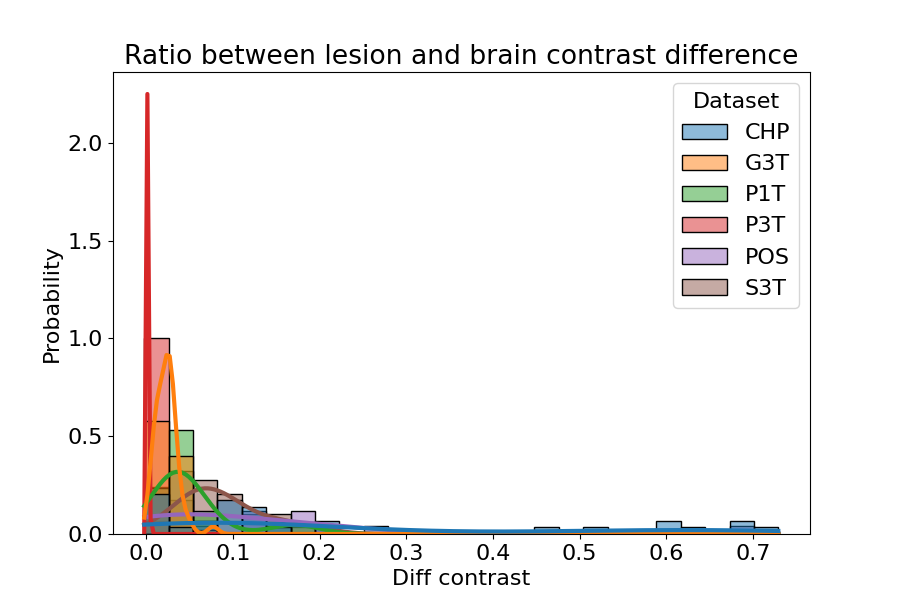

Text(0.5, 1.0, 'Ratio between lesion and brain contrast difference')

In [207]:
columns = [
    'Dataset', 'Lesions', 'Voxels', 'Voxels per lesion',
    'Lesion contrast', 'Brain contrast', 'Diff contrast'
]
subject_df = pd.DataFrame(subject_data, columns=columns)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sn.histplot(
    data=subject_df, x='Voxels', hue='Dataset',
    kde=True, common_norm=False, line_kws=dict(linewidth=3), stat='probability'
)
plt.title('Volume per subject distribution')
plt.subplot(1, 2, 2)
sn.histplot(
    data=subject_df, x='Voxels', hue='Dataset',
    common_norm=False, line_kws=dict(linewidth=3), stat='probability',
    cumulative=True, element='poly'
)
plt.title('Cumulative distribution (volume per subject)')

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sn.histplot(
    data=subject_df, x='Voxels per lesion', hue='Dataset',
    kde=True, common_norm=False, line_kws=dict(linewidth=3), stat='probability'
)
plt.title('Volume per lesion per subject')
plt.subplot(1, 2, 2)
sn.histplot(
    data=subject_df, x='Voxels per lesion', hue='Dataset',
    common_norm=False, line_kws=dict(linewidth=3), stat='probability',
    cumulative=True, element='poly'
)
plt.title('Cumulative distribution (volume per lesion per subject)')

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sn.histplot(
    data=subject_df, x='Lesions', hue='Dataset',
    kde=True, common_norm=False, line_kws=dict(linewidth=3), stat='probability'
)
plt.title('Lesions per subject')
plt.subplot(1, 2, 2)
sn.histplot(
    data=subject_df, x='Lesions', hue='Dataset',
    common_norm=False, line_kws=dict(linewidth=3), stat='probability',
    cumulative=True, element='poly'
)
plt.title('Cumulative distribution (lesions per subject)')

plt.figure(figsize=(9, 6))
sn.histplot(
    data=subject_df, x='Diff contrast', hue='Dataset',
    kde=True, common_norm=False, line_kws=dict(linewidth=3),  stat='probability'
)
plt.title('Ratio between lesion and brain contrast difference')

<IPython.core.display.Javascript object>


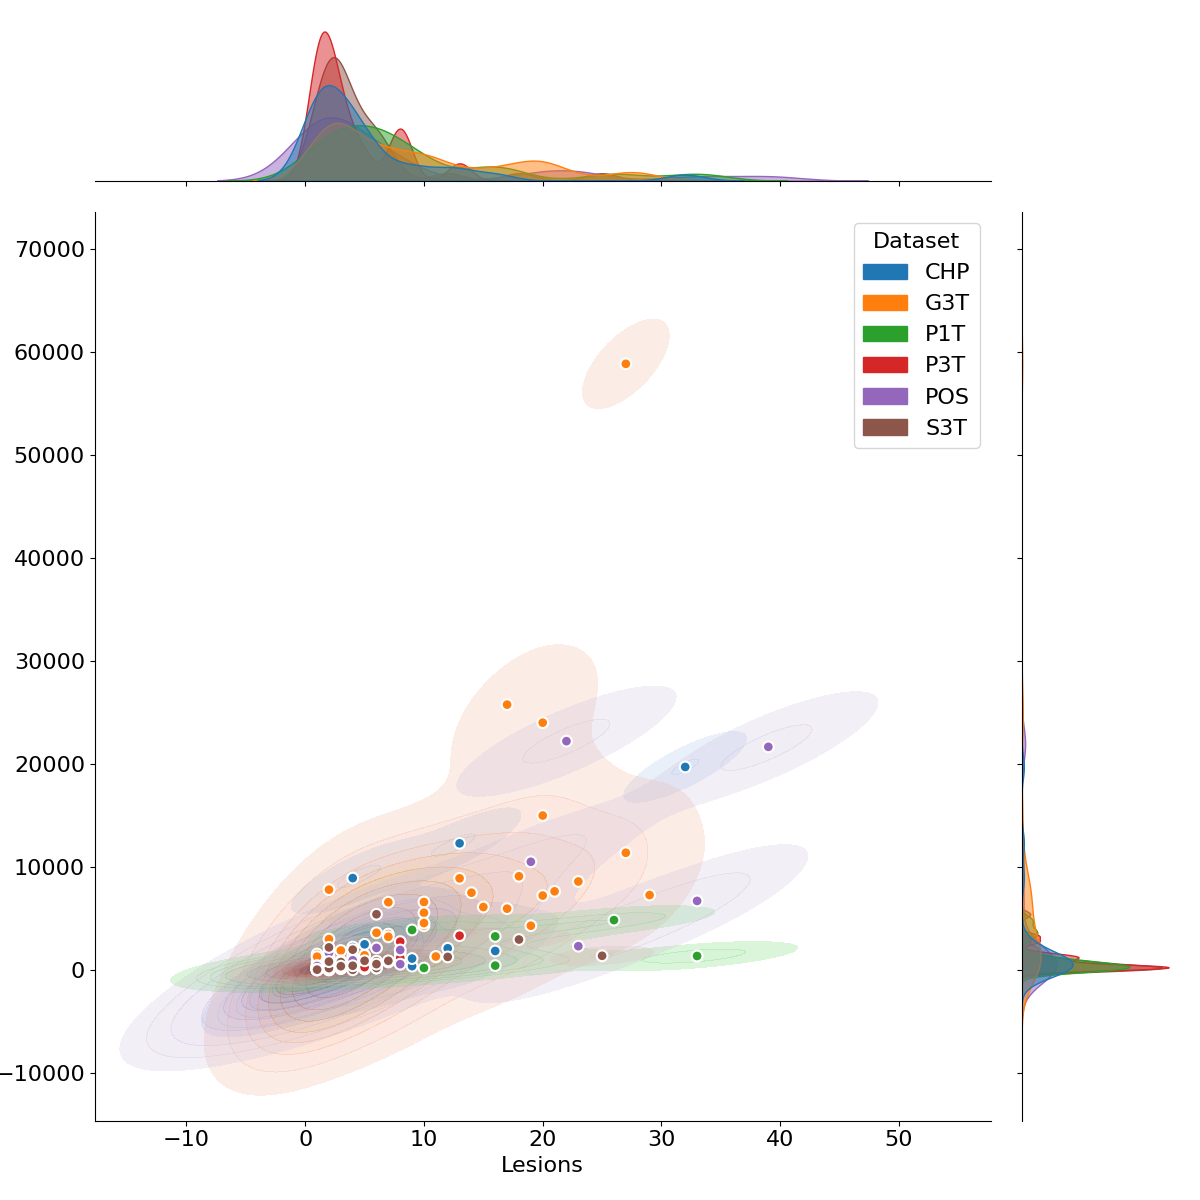

<IPython.core.display.Javascript object>


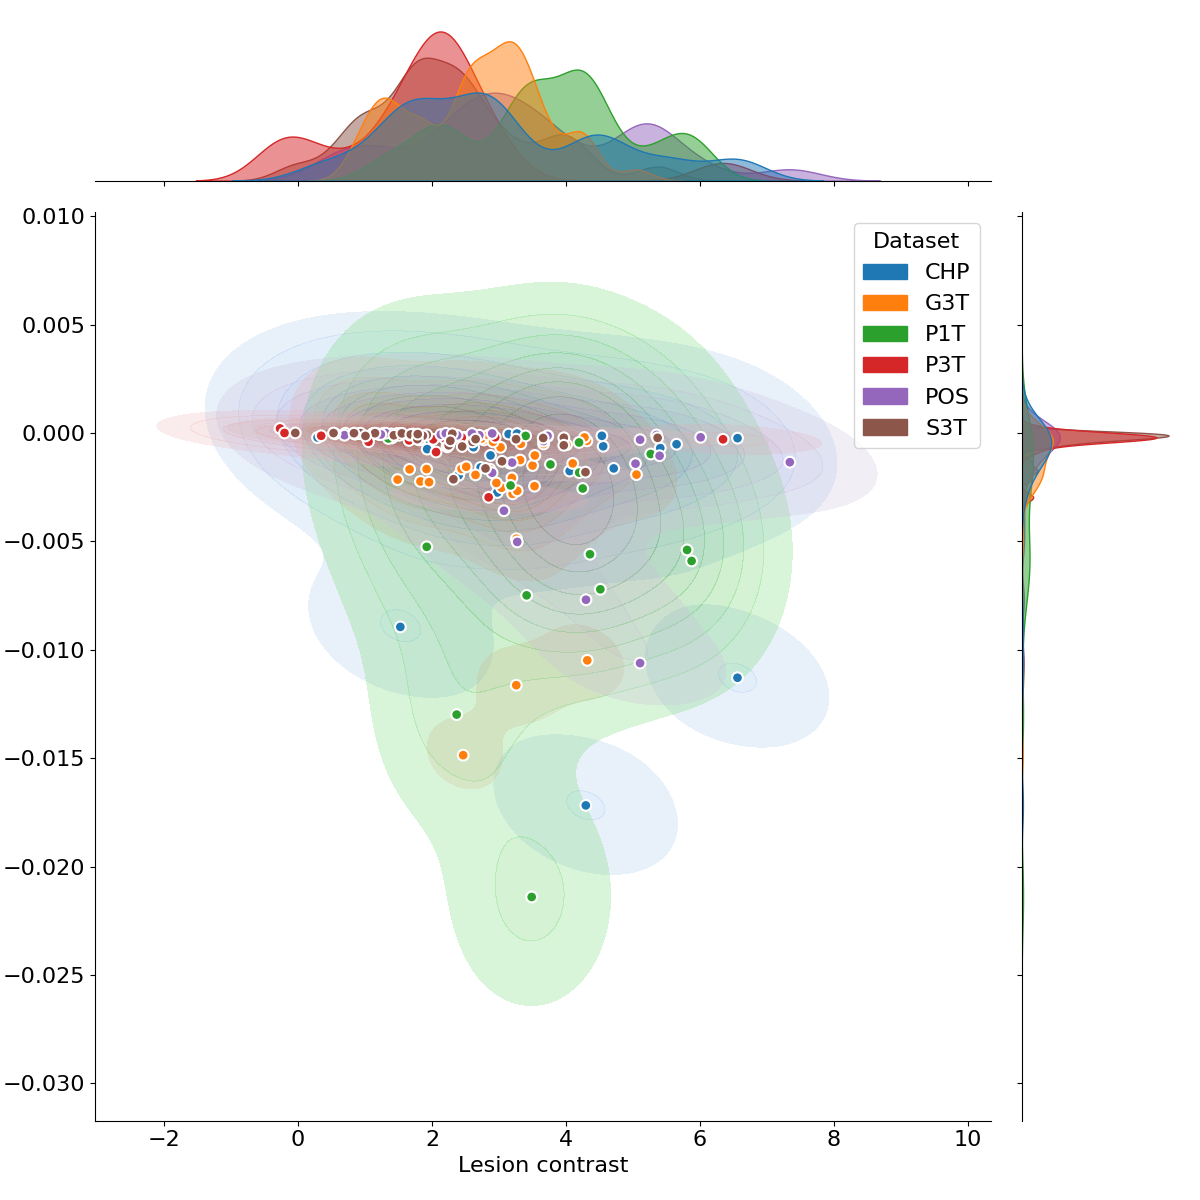

In [206]:
def plot_joint_distribution(data, x, y, hue, title='', height=12):
    g = sn.JointGrid(data=data, x=x, y=y, hue=hue, height=height)
    g.plot_joint(sn.kdeplot, alpha=.25, fill=True, common_norm=False)
    g.plot_marginals(sn.kdeplot, fill=True, common_norm=False, alpha=.5, bw_adjust=.5)
    fig = plt.gcf()
    #ax = fig.get_axes()[0]
    #plt.sca(ax)
    #plt.xlim(0, 100)
    #plt.ylim(0, 100)
    ax = fig.get_axes()[0]
    plt.sca(ax)

    sn.scatterplot(
        x=x, y=y, hue=hue,
        data=data, legend=None, 
        linewidth=1.5, s=60,
    )
    
plot_joint_distribution(data=subject_df, x='Lesions', y='Voxels', hue='Dataset')
plot_joint_distribution(data=subject_df, x='Lesion contrast', y='Brain contrast', hue='Dataset')

In [211]:
lesion_mean = subject_df['Lesions'].mean()
lesion_std = subject_df['Lesions'].std()
volume_mean = subject_df['Voxels'].mean()
volume_std = subject_df['Voxels'].std()
lvolume_mean = subject_df['Voxels per lesion'].mean()
lvolume_std = subject_df['Voxels per lesion'].std()

split_data = []
pi = 1
for index, row in subject_df.iterrows():
    print(' '.join([' '] * 300), end='\r')
    print('Subject {:} [{:03d}/{:03d}]'.format(index, pi, len(subject_df)), end='\r')
    lesions = (row['Lesions'] - lesion_mean) / lesion_std
    volume = (row['Voxels'] - volume_mean) / volume_std
    lvolume = (row['Voxels per lesion'] - lvolume_mean) / lvolume_std
    brain_contrast = row['Brain contrast']
    lesion_contrast = row['Lesion contrast']
    diff_contrast = row['Diff contrast']
    split_data.append([tag, 'Lesions', lesions])
    split_data.append([tag, 'Voxels per lesion', lvolume])
    split_data.append([tag, 'Diff contrast', diff_contrast])
    
    pi += 1

<IPython.core.display.Javascript object>


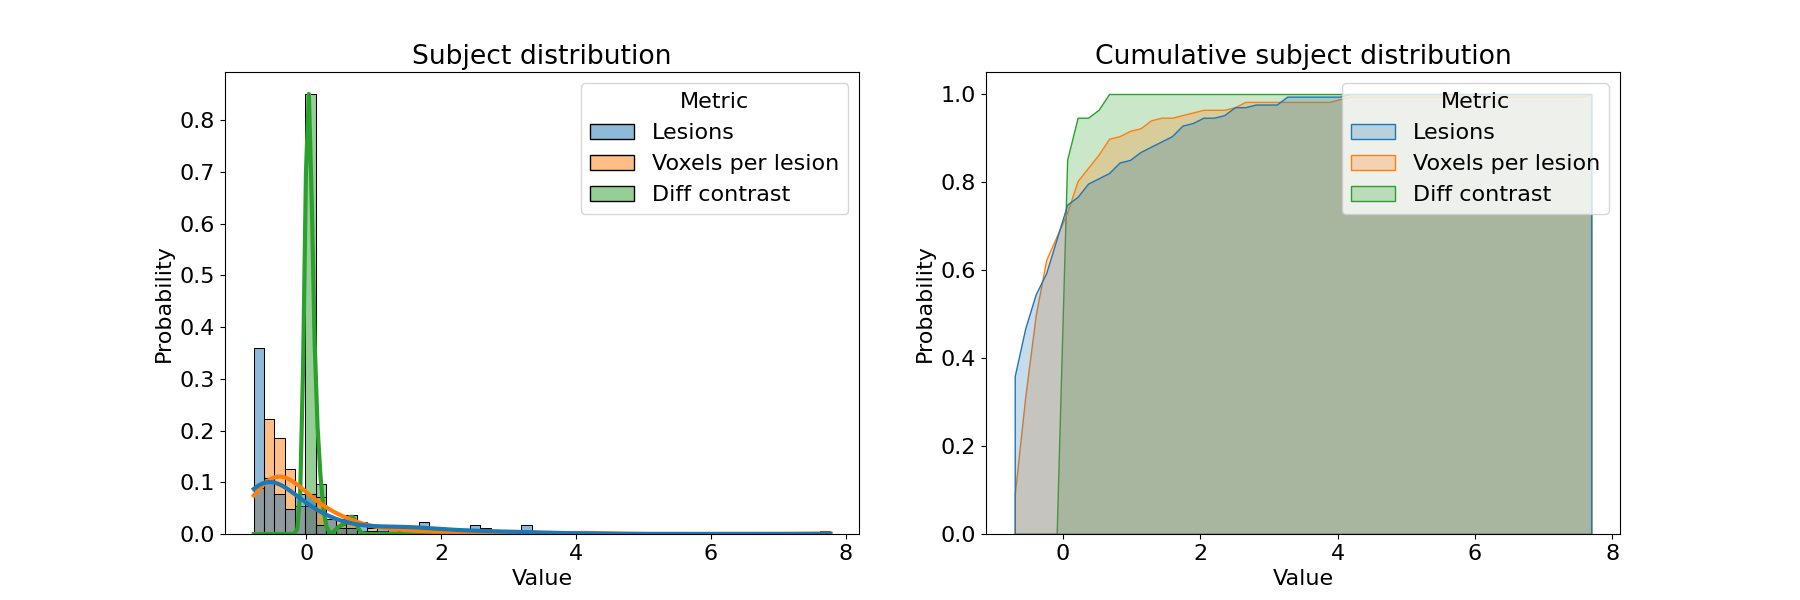

Text(0.5, 1.0, 'Cumulative subject distribution')

In [212]:
columns = ['Dataset', 'Metric', 'Value']
split_df = pd.DataFrame(split_data, columns=columns)

plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
sn.histplot(
    data=split_df, x='Value', hue='Metric',
    kde=True, common_norm=False, line_kws=dict(linewidth=3), stat='probability'
)
plt.title('Subject distribution')
plt.subplot(1, 2, 2)
sn.histplot(
    data=split_df, x='Value', hue='Metric',
    common_norm=False, line_kws=dict(linewidth=3), stat='probability',
    cumulative=True, element='poly'
)
plt.title('Cumulative subject distribution')